In [1]:
# 以下のtrainデータから特長量を作成し、学習モデルを生成させる。
# /mnt/c/Users/hayat/Desktop/keiba_analysis/data_for_train/train/2005_2022

In [2]:
!pip install lightGBM

In [3]:
import gc
gc.collect()

214

In [4]:
# /mnt/c/Users/hayat/Desktop/keiba_analysis/data_for_train/train/2005_2022
# のデータを取り込む

import warnings
from sklearn.svm import SVC, LinearSVC
from sklearn import multiclass
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
import scipy.stats
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import tqdm
# 指定したディレクトリ配下のcsvデータをreadする
# is_denso = False
# train_year_list = ["2023", "2024"]
# train_path = '/home/hayato/horse_inference/data_for_train/train_data/2024/'
# if is_denso:
#     train_path = '/home/denso/horse_inference/data_for_train/train_data/2024/'

# # train dataを読み込み
# train_data = pd.read_csv(train_path + "train_data_results_2024_update.csv", encoding='utf-8')
# # データが多いと落ちるので半分だけ取得
# # train_data = train_data[:int(len(train_data)/2)]
# print("train data length {}".format(len(train_data)))

# # 勝率データ、過去のデータを取得
# horse_past_data = pd.read_csv(train_path + 'horse_results_2024.csv', encoding='utf-8')  
# # データが多いと落ちるので半分だけ取得
# # horse_past_data = horse_past_data[:int(len(horse_past_data)/2)]  
# print("horse_past_data length {}".format(len(horse_past_data)))
# horse_peds_data = pd.read_csv(train_path + 'horse_born_results_2024.csv', encoding='utf-8')
# # train_data = train_data[:100000]
# # horse_peds_data = horse_peds_data[:int(len(horse_peds_data)/2)]
# print("horse_peds_data length {}".format(len(horse_peds_data)))
# # ジョッキーの過去データを取得
# jockey_past_data = pd.read_csv(train_path + 'jockey_results_2024.csv', encoding='utf-8')
# # jockeyデータはデータの中で"累計"が含まれているものだけを抽出
# # "年度"列が"累計"の行だけを抽出
# jockey_past_data = jockey_past_data[jockey_past_data['年度'] == '累計']

In [5]:
is_denso = False
train_year_list = ["2023", "2024"]
train_data = pd.DataFrame()
horse_past_data = pd.DataFrame()
horse_peds_data = pd.DataFrame()
jockey_past_data = pd.DataFrame()
for year in train_year_list:
    train_path = '/home/hayato/horse_inference/data_for_train/train_data/' + year + '/'
    if is_denso:
        train_path = '/home/denso/horse_inference/data_for_train/train_data/' + year + '/'
    # train dataに各年の学習データを縦方向に結合
    train_data = pd.concat([train_data, pd.read_csv(train_path + "train_data_results_" + year + ".csv", encoding='utf-8')], axis=0)
    print("train data length {}".format(len(train_data)))

    # 勝率データ、過去のデータを取得
    horse_past_data = pd.concat([horse_past_data, pd.read_csv(train_path + 'horse_results_' + year + '.csv', encoding='utf-8')], axis=0)
    print("horse_past_data length {}".format(len(horse_past_data)))
    horse_peds_data = pd.concat([horse_peds_data, pd.read_csv(train_path + 'horse_born_results_' + year + '.csv', encoding='utf-8')], axis=0)
    print("horse_peds_data length {}".format(len(horse_peds_data)))
    # ジョッキーの過去データを取得
    jockey_past_data = pd.concat([jockey_past_data, pd.read_csv(train_path + 'jockey_results_' + year + '.csv', encoding='utf-8')], axis=0)
    # jockeyデータはデータの中で"累計"が含まれているものだけを抽出
    # "年度"列が"累計"の行だけを抽出
    jockey_past_data = jockey_past_data[jockey_past_data['年度'] == '累計']
    print("jockey_past_data length {}".format(len(jockey_past_data)))

train data length 9371
horse_past_data length 99871
horse_peds_data length 4870
jockey_past_data length 161
train data length 54954
horse_past_data length 240812
horse_peds_data length 6463
jockey_past_data length 360


In [6]:
# horse_past_dataから最初のhorse_idの情報だけを抽出
first_horse_past_data = horse_past_data.drop_duplicates(subset='horse_id', keep='first')
# train_data = pd.merge(train_data, horse_peds_data, on='horse_id', how='left')

# train dataに対してhorse_past_data、horse_peds_dataをhorse_idをキーにして結合
train_data = pd.merge(train_data, first_horse_past_data, on='horse_id', how='left')
# train dataの情報を表示
print(train_data.info())
# train dataのデータ長を表示
print("train_data lenght :{}".format(len(train_data)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54954 entries, 0 to 54953
Data columns (total 49 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   着順            54954 non-null  object 
 1   枠番            54954 non-null  int64  
 2   馬番            54954 non-null  int64  
 3   馬名            54954 non-null  object 
 4   性齢            54954 non-null  object 
 5   斤量            54954 non-null  float64
 6   騎手_x          54954 non-null  object 
 7   タイム_x         54450 non-null  object 
 8   着差_x          50420 non-null  object 
 9   単勝            54954 non-null  object 
 10  人気            54728 non-null  float64
 11  馬体重_x         54954 non-null  object 
 12  調教師           54954 non-null  object 
 13  course_len    54954 non-null  int64  
 14  weather       54954 non-null  object 
 15  race_type     54954 non-null  object 
 16  ground_state  54954 non-null  object 
 17  date          54954 non-null  object 
 18  horse_id      54954 non-nu

In [7]:
# train_dataに対してjockey_past_dataをjockey_idをキーにして結合
# jockey_resultsから必要なjockey_idの情報だけを抽出
jockey_info = jockey_past_data[jockey_past_data['jockey_id'].isin(train_data['jockey_id'])]

train_data = pd.merge(train_data, jockey_info, on='jockey_id', how='left')
# train_data = pd.merge(train_data, jockey_past_data, on='jockey_id', how='left')
print(train_data.info())
# テスト的にtrain_dataのデータをcsvに保存
train_data.to_csv(train_path + "train_data_check.csv", index=False, encoding='utf-8')
print("train_data lenght :{}".format(len(train_data)))
train_data.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106225 entries, 0 to 106224
Data columns (total 60 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   着順            106225 non-null  object 
 1   枠番            106225 non-null  int64  
 2   馬番            106225 non-null  int64  
 3   馬名            106225 non-null  object 
 4   性齢            106225 non-null  object 
 5   斤量            106225 non-null  float64
 6   騎手_x          106225 non-null  object 
 7   タイム_x         105240 non-null  object 
 8   着差_x          97434 non-null   object 
 9   単勝            106225 non-null  object 
 10  人気            105780 non-null  float64
 11  馬体重_x         106225 non-null  object 
 12  調教師           106225 non-null  object 
 13  course_len    106225 non-null  int64  
 14  weather       106225 non-null  object 
 15  race_type     106225 non-null  object 
 16  ground_state  106225 non-null  object 
 17  date          106225 non-null  object 
 18  hors

,枠番,馬番,斤量,人気,course_len,horse_id,jockey_id,race_id,R,映 像,...,厩舎 ｺﾒﾝﾄ,備考,賞金,1着,2着,3着,4着〜,騎乗 回数,重賞 出走,重賞 勝利
count,106225.000000,106225.000000,106225.000000,105780.000000,106225.000000,1.062250e+05,106225.000000,1.062250e+05,106073.000000,0.0,...,0.0,0.0,34864.000000,106225.000000,106225.000000,106225.000000,106225.000000,106225.000000,106225.000000,106225.000000
mean,4.773217,7.613189,55.691697,7.570911,1653.168087,2.020308e+09,1409.174855,2.023880e+11,7.475088,NaN,...,NaN,NaN,405.330963,581.298018,568.028534,555.579760,5343.923784,7048.830096,315.783507,24.010835
std,2.265901,4.357596,1.847360,4.341930,422.575048,1.343905e+06,1100.795247,3.930585e+07,3.315963,NaN,...,NaN,NaN,1270.540512,719.024903,617.881980,556.901568,4298.809238,5957.141065,401.220181,50.388286
min,1.000000,1.000000,49.000000,1.000000,1000.000000,2.012101e+09,422.000000,2.023010e+11,1.000000,NaN,...,NaN,NaN,2.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000
25%,3.000000,4.000000,55.000000,4.000000,1200.000000,2.019107e+09,1096.000000,2.024030e+11,5.000000,NaN,...,NaN,NaN,40.000000,108.000000,117.000000,130.000000,1882.000000,2199.000000,29.000000,0.000000
50%,5.000000,7.000000,56.000000,7.000000,1700.000000,2.021100e+09,1160.000000,2.024051e+11,8.000000,NaN,...,NaN,NaN,130.000000,312.000000,345.000000,364.000000,3856.000000,4790.000000,169.000000,7.000000
75%,7.000000,11.000000,57.000000,11.000000,1800.000000,2.021105e+09,1187.000000,2.024080e+11,10.000000,NaN,...,NaN,NaN,400.000000,853.000000,897.000000,928.000000,8772.000000,11616.000000,518.000000,23.000000
max,8.000000,18.000000,65.000000,18.000000,4250.000000,2.022110e+09,5667.000000,2.024100e+11,12.000000,NaN,...,NaN,NaN,50340.200000,4559.000000,3451.000000,2772.000000,18808.000000,24936.000000,2047.000000,363.000000


In [8]:
train_data_for_ranking = train_data.copy()


In [9]:
inference_page_id = 2025050101

inference_data_path = "/home/hayato/horse_inference/inference/" + str(inference_page_id) + "/add_dynamic_data/"
if is_denso:
    inference_data_path = "/home/denso/horse_inference/inference/" + str(inference_page_id) + "/add_dynamic_data/"

In [10]:
train_data


,着順,枠番,馬番,馬名,性齢,斤量,騎手_x,タイム_x,着差_x,単勝,...,1着,2着,3着,4着〜,騎乗 回数,重賞 出走,重賞 勝利,勝率,連対率,複勝率
0,1,5,5,サトミノキラリ,牡2,55.0,横山武史,1:09.5,NaN,1.2,...,661,556,543,3907,5667,274,23,11.7％,21.5％,31.1％
1,1,5,5,サトミノキラリ,牡2,55.0,横山武史,1:09.5,NaN,1.2,...,660,555,539,3899,5653,272,23,11.7％,21.5％,31.0％
2,2,8,8,ベアゴーゴー,牝2,55.0,浜中俊,1:09.5,クビ,4.1,...,1211,1161,1052,7817,11241,718,58,10.8％,21.1％,30.5％
3,2,8,8,ベアゴーゴー,牝2,55.0,浜中俊,1:09.5,クビ,4.1,...,1211,1161,1050,7810,11232,717,58,10.8％,21.1％,30.5％
4,3,6,6,ハピアーザンエバー,牡2,55.0,藤岡佑介,1:10.0,2.1/2,59.9,...,1059,1050,1039,8818,11966,726,48,8.9％,17.6％,26.3％
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106220,13,5,8,シブースト,牝4,53.0,吉村誠之,1:49.0,大,167.0,...,38,36,43,496,613,4,0,6.2％,12.1％,19.1％
106221,14,8,15,ペイシャコパ,牝3,50.0,河原田菜,1:49.1,3/4,85.7,...,21,27,33,649,730,1,0,2.9％,6.6％,11.1％
106222,14,8,15,ペイシャコパ,牝3,50.0,河原田菜,1:49.1,3/4,85.7,...,20,27,33,643,723,1,0,2.8％,6.5％,11.1％
106223,15,1,1,オリーボーレン,牝3,53.0,坂井瑠星,1:54.7,大,10.6,...,528,476,446,3709,5159,285,19,10.2％,19.5％,28.1％


In [11]:
train_data.info()
train_data_mlp = train_data.copy()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106225 entries, 0 to 106224
Data columns (total 60 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   着順            106225 non-null  object 
 1   枠番            106225 non-null  int64  
 2   馬番            106225 non-null  int64  
 3   馬名            106225 non-null  object 
 4   性齢            106225 non-null  object 
 5   斤量            106225 non-null  float64
 6   騎手_x          106225 non-null  object 
 7   タイム_x         105240 non-null  object 
 8   着差_x          97434 non-null   object 
 9   単勝            106225 non-null  object 
 10  人気            105780 non-null  float64
 11  馬体重_x         106225 non-null  object 
 12  調教師           106225 non-null  object 
 13  course_len    106225 non-null  int64  
 14  weather       106225 non-null  object 
 15  race_type     106225 non-null  object 
 16  ground_state  106225 non-null  object 
 17  date          106225 non-null  object 
 18  hors

In [12]:
# 前処理
def preprocess(train_data, is_ranking=False, is_mlp=False):
    # 不要な特長量であるUnnamed: 0、class_list_in_raceを削除する
    # train_data = train_data.drop(['馬名','騎手_x', '人気',"調教師","枠番"], axis=1)
    # これはlightGBMによる成約であり、0からクラス数-1の目的変数にラベリングしなければならない

    # 着順はobject型であるため、int型に変換する。"除"、"中"のような文字列だった場合は100に変換する
    train_data['着順'] = train_data['着順'].replace('除', 100).replace('中', 100).replace('取', 100).replace('計不', 100)
    # 着順が計不の場合は100に変換する
    train_data['着順'] = train_data['着順'].replace('計不', 100)
    train_data['着順'] = train_data['着順'].astype(int)
    train_data['goal_number'] = train_data['着順']

    if not is_ranking:
        # ランキング学習でない場合は通常のグルーピング
        # 目的変数であるgoal_numberをグルーピングする。1であれば0、2と3は1にまとめる、4以上は2にまとめる
        train_data['goal_number'] = train_data['goal_number'].replace(
            {1: 0, 2: 1, 3: 1}
        ).apply(lambda x: 2 if x >= 4 else x)
    else:
        # ランキング学習の場合は1位が30、2位が28、3位が26、残りは0の着順関連度に変換する。
        # goal numberをスコア化
        # ランキング学習の場合は1位が30、2位が28、3位が26、残りは0の着順関連度に変換する。
        # ->評価指標(NDCG)に合わせて指数関数的にスコアをつける
        train_data['goal_number_replace'] = train_data['goal_number'].apply(
            lambda x: 7 if x == 1 else (3 if x == 2 else (1 if x == 3 else 0)))
    
    # inference に合わせて前処理を実施
    # 性齢の1文字から性別を取得しhorse_sexへ、2文字目以降から年齢を取得しhorse_ageへ格納する
    train_data['horse_sex'] = train_data['性齢'].apply(lambda x: x[0])
    train_data['horse_age'] = train_data['性齢'].apply(lambda x: int(x[1:]))
    # 馬体重_xから体重と、()内の増減を取得する
    # 馬体重が計不の場合は500
    train_data['馬体重_x'] = train_data['馬体重_x'].replace('計不', '500(0)')
    train_data['horse_weight'] = train_data['馬体重_x'].apply(lambda x: int(x.split('(')[0]))
    train_data['weight_change'] = train_data['馬体重_x'].apply(lambda x: int(x.split('(')[1].replace(')', '')))
    # 斤量を取得しhandiに格納する
    train_data['handi'] = train_data['斤量'].apply(lambda x: int(x))
    # course_lenを取得しdistanceに格納する
    train_data['distance'] = train_data['course_len'].apply(lambda x: int(x))
    # race_typeを取得し1文字目を取得しconditionに格納する
    train_data['condition'] = train_data['race_type'].apply(lambda x: x[0])
    # 馬番を取得しumabanに格納する
    train_data['umaban'] = train_data['馬番'].apply(lambda x: int(x))
    # 単勝を取得しoddsに格納する
    # 単勝が---の場合は100に変換する
    train_data['単勝'] = train_data['単勝'].replace('---', 100)
    train_data['odds'] = train_data['単勝'].apply(lambda x: float(x))
    # タイム_yは1:34.0のような形式なので、秒に変換する
    # nanの場合は100に変換する
    # 'タイム_y'列の値を文字列に変換し、NaN値を無視して処理を行う
    train_data['タイム_y'] = train_data['タイム_y'].astype(str).apply(
        lambda x: int(x.split(':')[0]) * 60 + float(x.split(':')[1]) if ':' in x else np.nan
    )

    # 'ペース'列の値を文字列に変換し、NaN値を無視して処理を行う
    train_data['pace1'] = train_data['ペース'].astype(str).apply(
        lambda x: float(x.split('-')[0]) if '-' in x else np.nan
    )
    train_data['pace2'] = train_data['ペース'].astype(str).apply(
        lambda x: float(x.split('-')[1]) if '-' in x else np.nan
    )

    # 馬体重_yは480(+2)のような形式なので、体重と増減を分ける
    train_data['馬体重_y'] = train_data['馬体重_y'].replace('計不', '500(0)')
    train_data['horse_weight_y'] = train_data['馬体重_y'].apply(lambda x: int(x.split('(')[0]))
    # 'weight_change_y'列を作成し、'馬体重_y'列の値を処理
    train_data['weight_change_y'] = train_data['馬体重_y'].apply(
        lambda x: int(x.split('(')[1].replace(')', '')) if '(' in x else np.nan
    )

    # '連対率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    train_data['連対率'] = train_data['連対率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) else x
    )

    # '勝率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    train_data['勝率'] = train_data['勝率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) else x
    )

    # '複勝率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    train_data['複勝率'] = train_data['複勝率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) else x
    )
    # columnの名前を確認し、:や 、"、'がある場合は_に置き換える
    # train_data.columns = train_data.columns.str.replace(":", "_")
    # train_data.columns = train_data.columns.str.replace(",", "_")
    # train_data.columns = train_data.columns.str.replace("'", "_")
    # train_data.columns = train_data.columns.str.replace('"', "_")
    # train_data.columns = train_data.columns.str.replace(" ", "_")

    # train dataのカラム情報を表示
    print(train_data.columns)

    # 学習、推論データの特長量を定義する
    target_feature = 'goal_number'
    features = [
        'distance',
        'condition',
        'umaban', # 100%になったし、そもそも不要なのでコメントアウト
        'horse_age',
        'horse_sex',
        # 'horse_weight', # 馬の体重は引っ張ってこれないのでコメントアウト
        # 'weight_change',
        'handi',
        'odds',
        # ここまではtrain_resultとinferenceから抽出できる共通データ

        # ここからは馬の過去データから抽出できるので必要な情報を追加する
        '天 気',
        '頭 数',
        '枠番',
        '馬番',
        'オ ッ ズ',
        '人気',
        # '着順', # 目的変数なので削除する
        '斤量',
        '距離',
        '馬 場',
        'タイム_y',
        'pace1',
        'pace2',
        '上り',
        'horse_weight_y',
        'weight_change_y',
        '賞金',
        # # ここからはジョッキーの過去データから抽出できるので必要な情報を追加する
        '1着',
        '2着',
        '3着',
        '4着〜',
        '騎乗 回数',
        '重賞 出走',
        '重賞 勝利',
        '勝率',
        '連対率',
        '複勝率',
    ]
    if is_mlp:
        # race idを追加する
        features += ["race_id"]
        features += ["着順"]
    # 特長量を抽出する
    if is_ranking:
        train_data = train_data[features + [target_feature] + ['goal_number_replace']]
    else:
        train_data = train_data[features + [target_feature]]
    # inference_dataの特長量のobject型は、LabelEncoderで数値に変換する
    # object型の特長量を確認する
    object_columns = train_data.select_dtypes(include='object').columns
    object_columns
    for column in object_columns:
        le = LabelEncoder()
        # object型は別のラベル名にてラベルエンコーディングする
        train_data[column] = le.fit_transform(train_data[column])
    # 学習データが大きすぎるので、train_dataの上から1000行を取得して学習データとする
    # if not is_ranking:
    #     train_data = train_data[:50000]
    print(train_data.info())
    return train_data

train_data = preprocess(train_data)
# mlp用にコピーする
train_data_mlp = preprocess(train_data_mlp, is_mlp=True)   


Index(['着順', '枠番', '馬番', '馬名', '性齢', '斤量', '騎手_x', 'タイム_x', '着差_x', '単勝', '人気',
       '馬体重_x', '調教師', 'course_len', 'weather', 'race_type', 'ground_state',
       'date', 'horse_id', 'jockey_id', 'race_id', '日付', '開催', '天 気', 'R',
       'レース名', '映 像', '頭 数', '枠 番', '馬 番', 'オ ッ ズ', '人 気', '着 順', '騎手_y',
       '斤 量', '距離', '馬 場', '馬場 指数', 'タイム_y', '着差_y', 'ﾀｲﾑ 指数', '通過', 'ペース',
       '上り', '馬体重_y', '厩舎 ｺﾒﾝﾄ', '備考', '勝ち馬 (2着馬)', '賞金', '年度', '1着', '2着',
       '3着', '4着〜', '騎乗 回数', '重賞 出走', '重賞 勝利', '勝率', '連対率', '複勝率',
       'goal_number', 'horse_sex', 'horse_age', 'horse_weight',
       'weight_change', 'handi', 'distance', 'condition', 'umaban', 'odds',
       'pace1', 'pace2', 'horse_weight_y', 'weight_change_y'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106225 entries, 0 to 106224
Data columns (total 34 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   distance         106225 non-null  int64 

/tmp/ipykernel_14653/2102171454.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_14653/2102171454.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_14653/2102171454.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Index(['着順', '枠番', '馬番', '馬名', '性齢', '斤量', '騎手_x', 'タイム_x', '着差_x', '単勝', '人気',
       '馬体重_x', '調教師', 'course_len', 'weather', 'race_type', 'ground_state',
       'date', 'horse_id', 'jockey_id', 'race_id', '日付', '開催', '天 気', 'R',
       'レース名', '映 像', '頭 数', '枠 番', '馬 番', 'オ ッ ズ', '人 気', '着 順', '騎手_y',
       '斤 量', '距離', '馬 場', '馬場 指数', 'タイム_y', '着差_y', 'ﾀｲﾑ 指数', '通過', 'ペース',
       '上り', '馬体重_y', '厩舎 ｺﾒﾝﾄ', '備考', '勝ち馬 (2着馬)', '賞金', '年度', '1着', '2着',
       '3着', '4着〜', '騎乗 回数', '重賞 出走', '重賞 勝利', '勝率', '連対率', '複勝率',
       'goal_number', 'horse_sex', 'horse_age', 'horse_weight',
       'weight_change', 'handi', 'distance', 'condition', 'umaban', 'odds',
       'pace1', 'pace2', 'horse_weight_y', 'weight_change_y'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106225 entries, 0 to 106224
Data columns (total 36 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   distance         106225 non-null  int64 

/tmp/ipykernel_14653/2102171454.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_14653/2102171454.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_14653/2102171454.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [13]:
# 特長量の前処理①対数変換
def log_transform(train_data):
    # 対数変換を行う特長量を定義する。対象はスケールの大きいもの、右に裾が長いもの、指数的に増加するものがある。
    log_features = [
        # 'distance',
        'odds',
        'オ ッ ズ',
        # 'タイム_y',
        # '4着〜',
        # '騎乗 回数'
    ]
    # 対数変換を行う
    for feature in log_features:
        train_data[feature] = np.log1p(train_data[feature])
    return train_data

# train_data = log_transform(train_data)

In [14]:
# 特長量の前処理②標準化
def standard_scaler(train_data):
    # 標準化を行う特長量を定義する。標準化は特長量のスケールを揃えるために行う。ラベルエンコーディングされた特長量以外は基本実施
    standard_features = [
        'distance',
        # 'condition',
        # 'umaban', # 100%になったし、そもそも不要なのでコメントアウト
        # 'horse_age',
        # 'horse_sex',
        'horse_weight',
        'weight_change',
        'handi',
        'odds',
        # ここまではtrain_resultとinferenceから抽出できる共通データ

        # ここからは馬の過去データから抽出できるので必要な情報を追加する
        # '天 気',
        '頭 数',
        # '枠番',
        # '馬番',
        'オ ッ ズ',
        '人気',
        # '着順', # 目的変数なので削除する
        '斤量',
        # '距離',  # ラベルなので削除
        # '馬 場',
        'タイム_y',
        'pace1',
        'pace2',
        '上り',
        'horse_weight_y',
        'weight_change_y',
        '賞金',
        # # ここからはジョッキーの過去データから抽出できるので必要な情報を追加する
        '1着',
        '2着',
        '3着',
        '4着〜',
        '騎乗 回数',
        '重賞 出走',
        '重賞 勝利',
        '勝率',
        '連対率',
        '複勝率',
    ]
    # 標準化実施
    scaler = StandardScaler()
    train_data[standard_features] = scaler.fit_transform(train_data[standard_features])
    return train_data

# train_data = standard_scaler(train_data)
    

In [15]:
train_data.info()

# # train_dataの中からgoal_numberとついたすべての名前の特長量を削除する
# train_data = train_data.drop(train_data.filter(like='goal_number').columns, axis=1)

# #inference_dataも同様にgoal_numbearとついたすべての名前の特長量を削除する
# inference_data = inference_data.drop(inference_data.filter(like='goal_number').columns, axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106225 entries, 0 to 106224
Data columns (total 34 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   distance         106225 non-null  int64  
 1   condition        106225 non-null  int64  
 2   umaban           106225 non-null  int64  
 3   horse_age        106225 non-null  int64  
 4   horse_sex        106225 non-null  int64  
 5   handi            106225 non-null  int64  
 6   odds             106225 non-null  float64
 7   天 気              106225 non-null  int64  
 8   頭 数              106212 non-null  float64
 9   枠番               106225 non-null  int64  
 10  馬番               106225 non-null  int64  
 11  オ ッ ズ            105194 non-null  float64
 12  人気               105780 non-null  float64
 13  斤量               106225 non-null  float64
 14  距離               106225 non-null  int64  
 15  馬 場              106225 non-null  int64  
 16  タイム_y            103834 non-null  floa

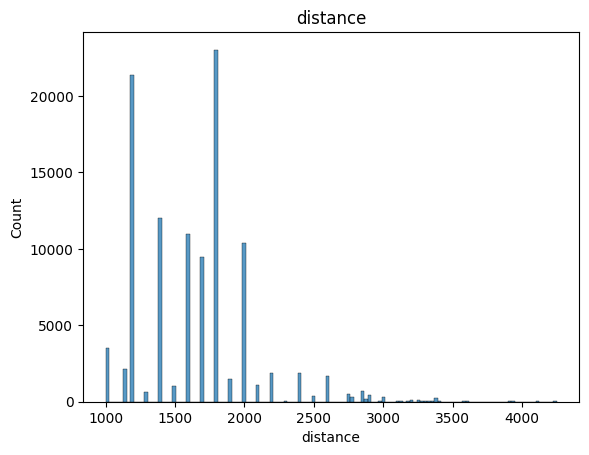

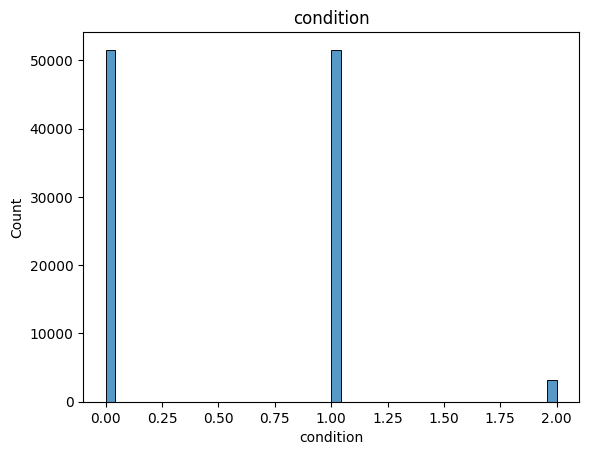

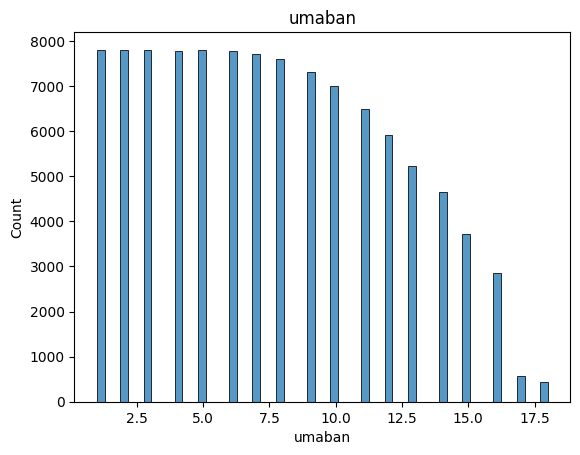

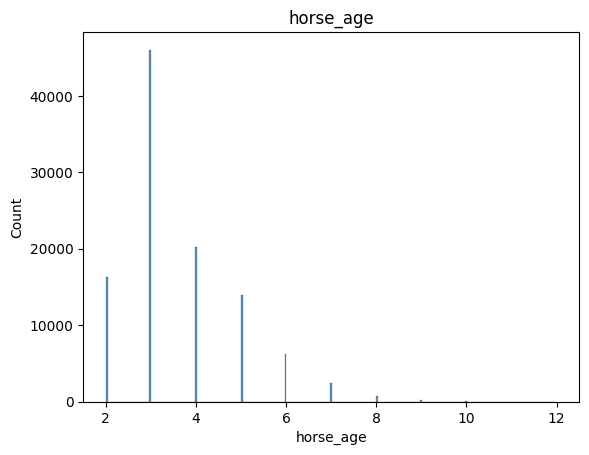

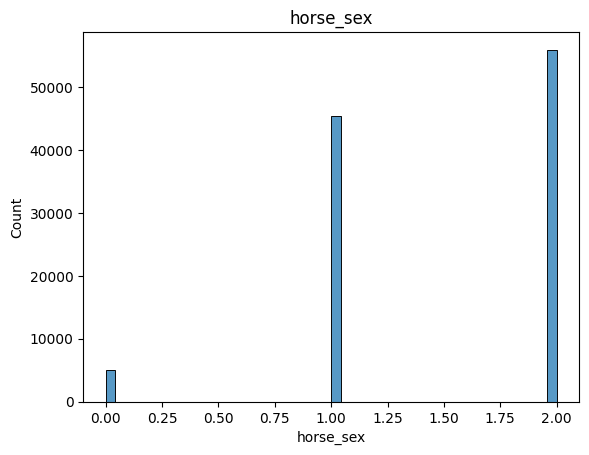

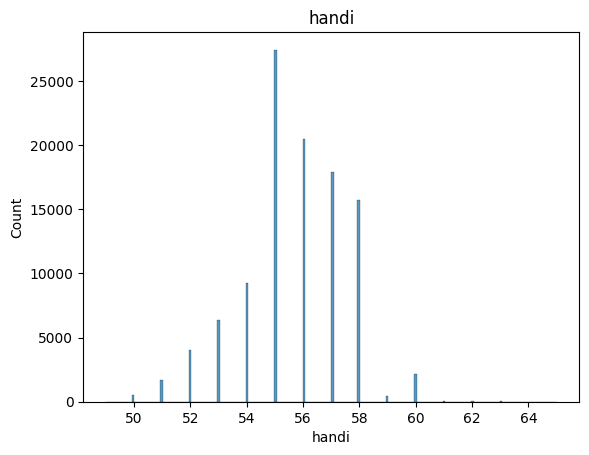

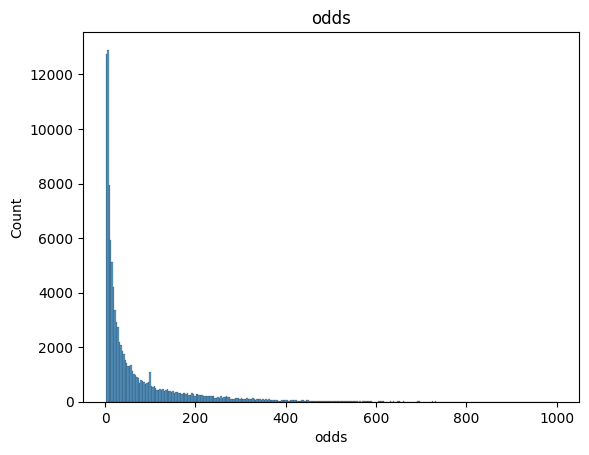

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22825 (\N{CJK UNIFIED IDEOGRAPH-5929}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27671 (\N{CJK UNIFIED IDEOGRAPH-6C17}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


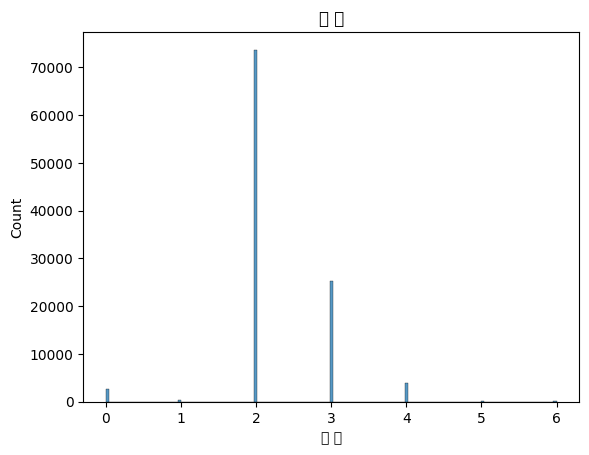

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38957 (\N{CJK UNIFIED IDEOGRAPH-982D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


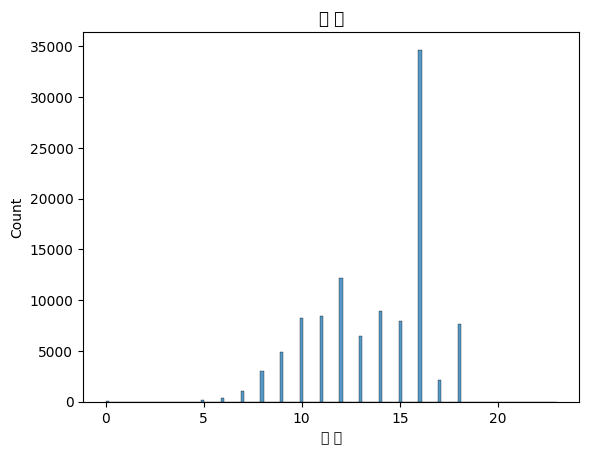

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26528 (\N{CJK UNIFIED IDEOGRAPH-67A0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30058 (\N{CJK UNIFIED IDEOGRAPH-756A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


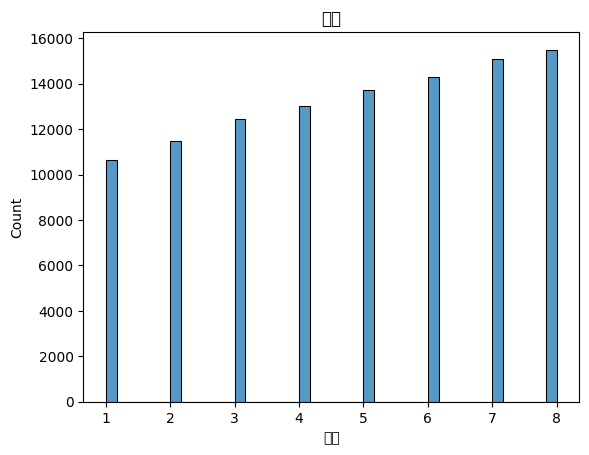

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39340 (\N{CJK UNIFIED IDEOGRAPH-99AC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30058 (\N{CJK UNIFIED IDEOGRAPH-756A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


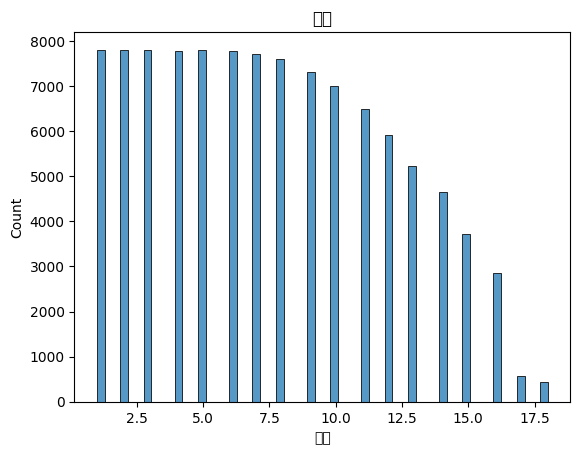

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12458 (\N{KATAKANA LETTER O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12474 (\N{KATAKANA LETTER ZU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


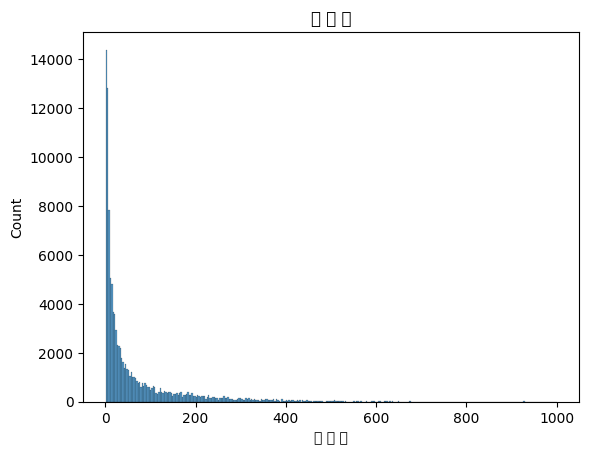

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 27671 (\N{CJK UNIFIED IDEOGRAPH-6C17}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


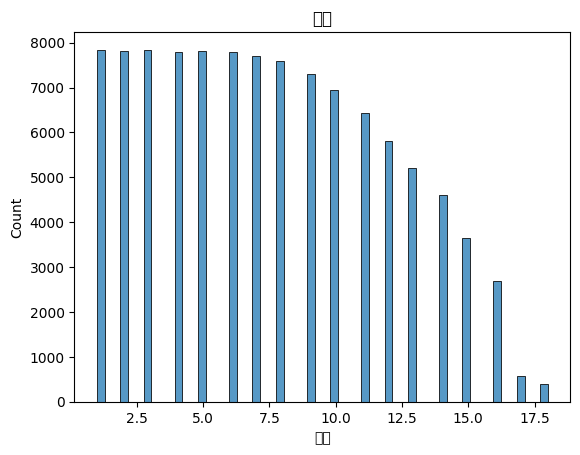

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26020 (\N{CJK UNIFIED IDEOGRAPH-65A4}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


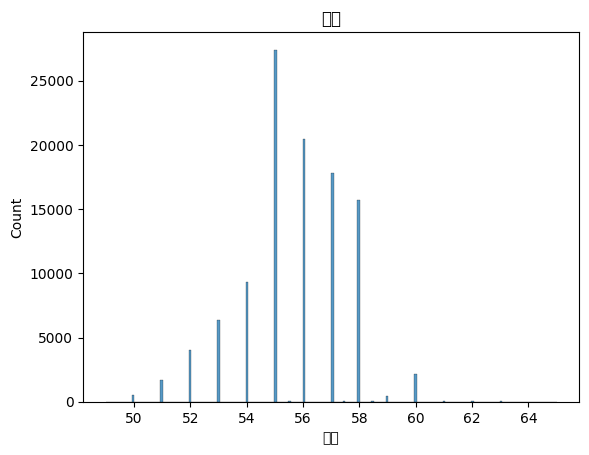

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38626 (\N{CJK UNIFIED IDEOGRAPH-96E2}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


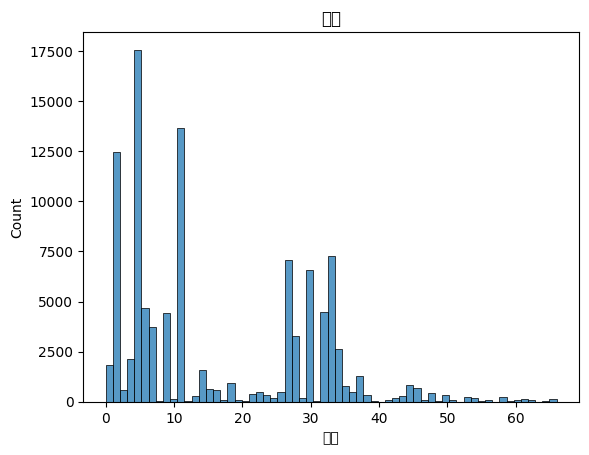

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39340 (\N{CJK UNIFIED IDEOGRAPH-99AC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22580 (\N{CJK UNIFIED IDEOGRAPH-5834}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


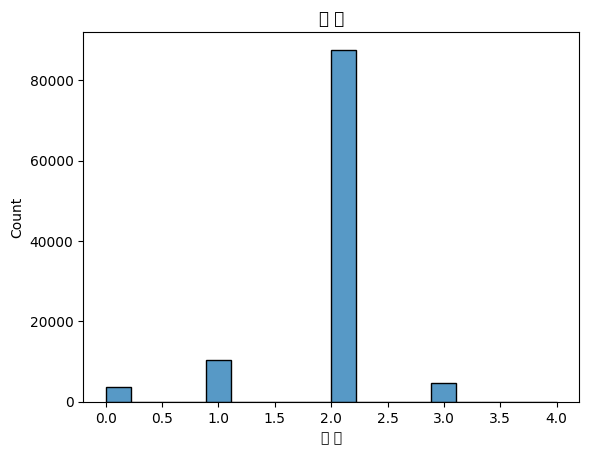

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12452 (\N{KATAKANA LETTER I}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12512 (\N{KATAKANA LETTER MU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


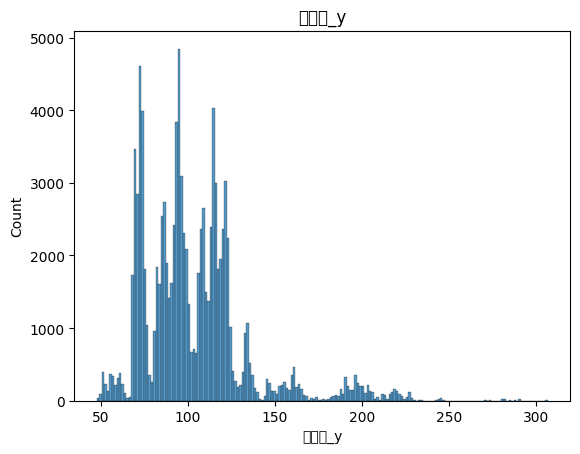

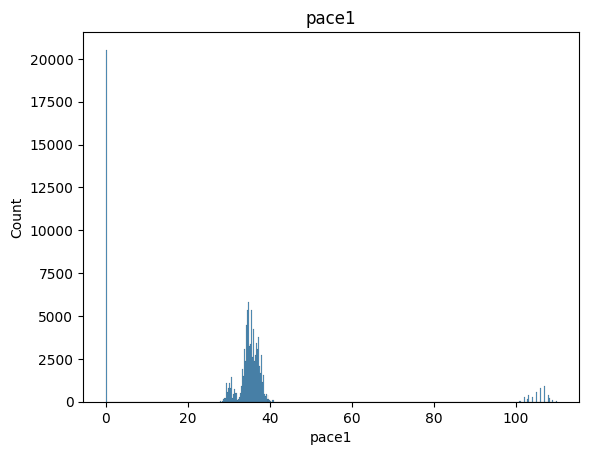

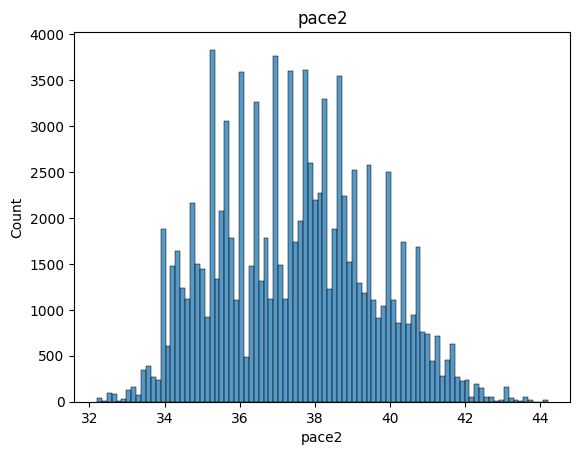

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 19978 (\N{CJK UNIFIED IDEOGRAPH-4E0A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12426 (\N{HIRAGANA LETTER RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


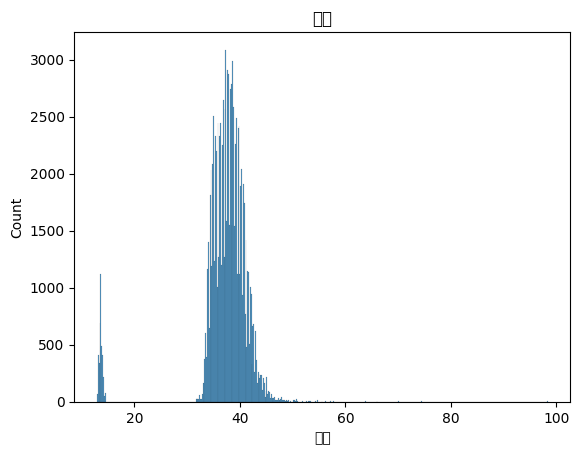

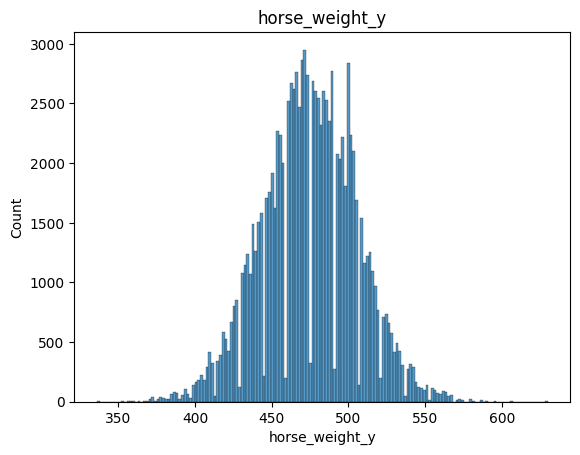

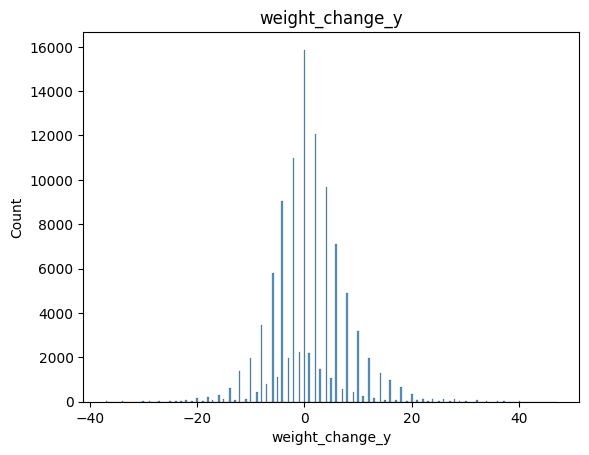

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36062 (\N{CJK UNIFIED IDEOGRAPH-8CDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


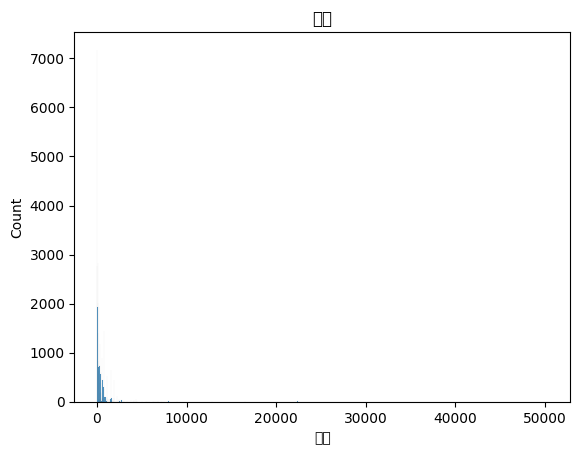

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


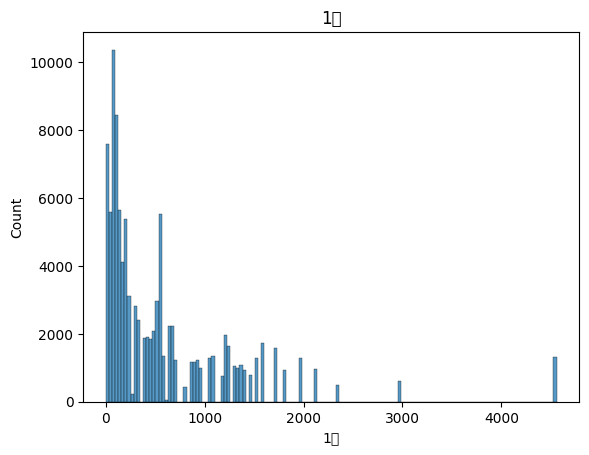

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


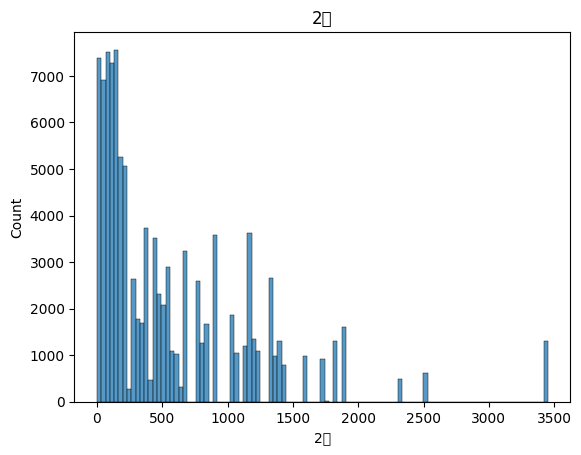

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


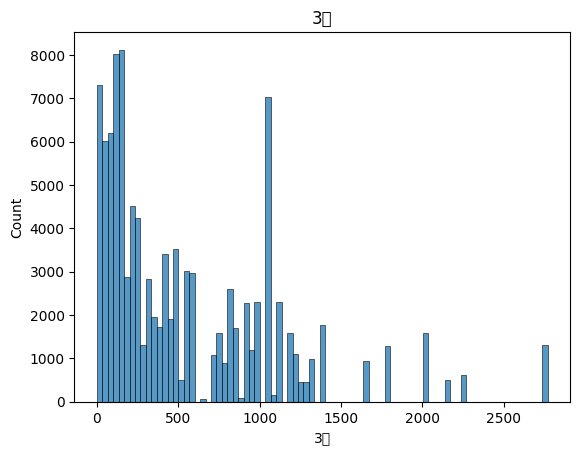

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 30528 (\N{CJK UNIFIED IDEOGRAPH-7740}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12316 (\N{WAVE DASH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


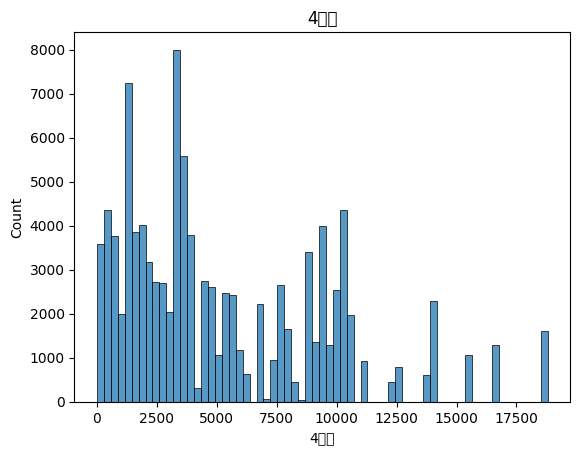

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39438 (\N{CJK UNIFIED IDEOGRAPH-9A0E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20055 (\N{CJK UNIFIED IDEOGRAPH-4E57}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


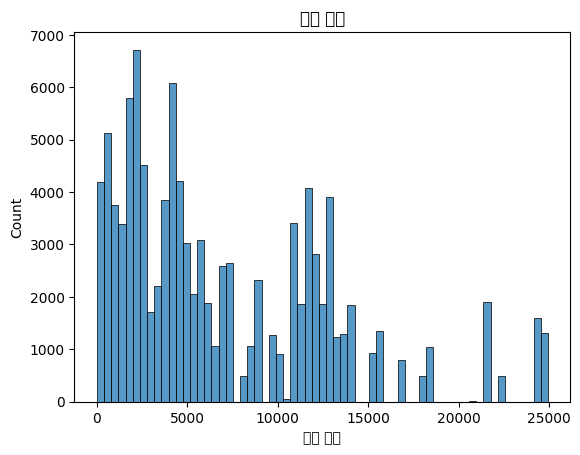

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36062 (\N{CJK UNIFIED IDEOGRAPH-8CDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20986 (\N{CJK UNIFIED IDEOGRAPH-51FA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36208 (\N{CJK UNIFIED IDEOGRAPH-8D70}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


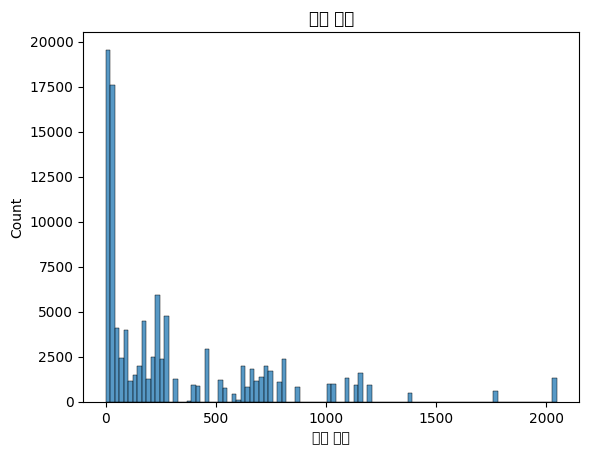

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36062 (\N{CJK UNIFIED IDEOGRAPH-8CDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21213 (\N{CJK UNIFIED IDEOGRAPH-52DD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21033 (\N{CJK UNIFIED IDEOGRAPH-5229}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


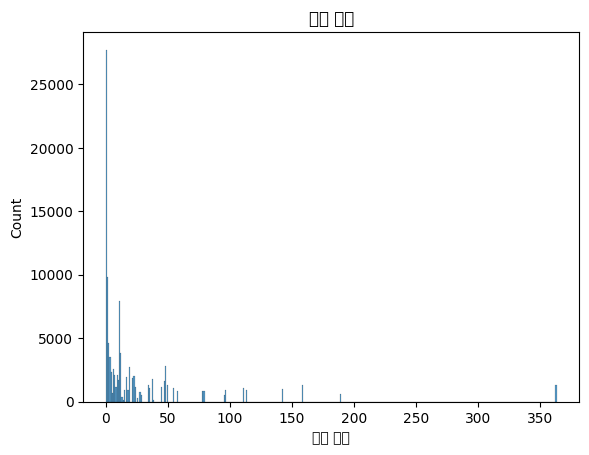

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21213 (\N{CJK UNIFIED IDEOGRAPH-52DD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


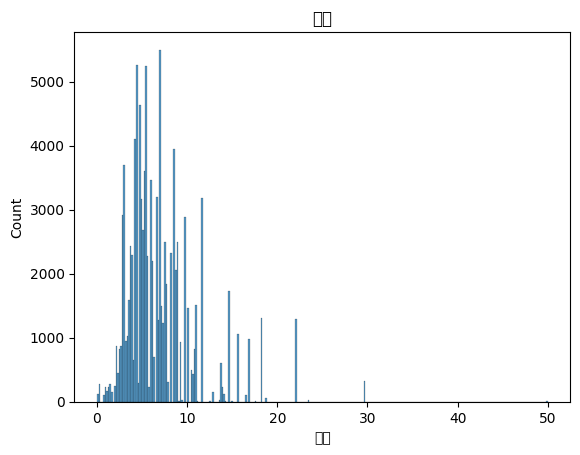

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36899 (\N{CJK UNIFIED IDEOGRAPH-9023}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 23550 (\N{CJK UNIFIED IDEOGRAPH-5BFE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


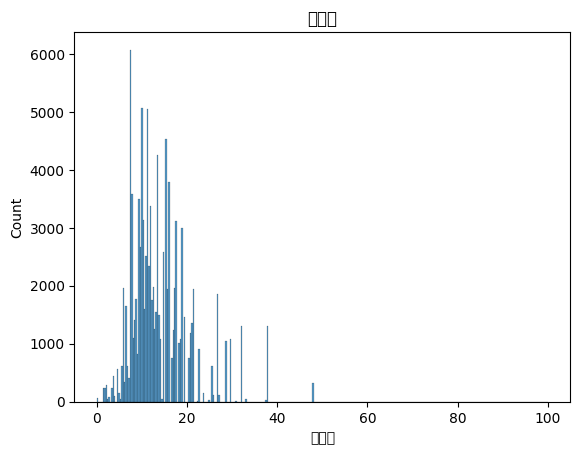

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35079 (\N{CJK UNIFIED IDEOGRAPH-8907}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21213 (\N{CJK UNIFIED IDEOGRAPH-52DD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


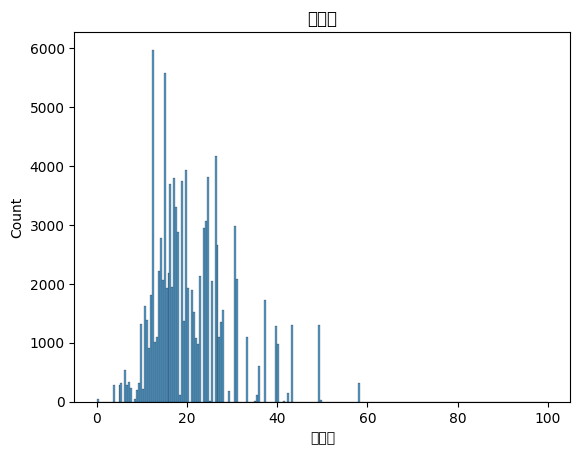

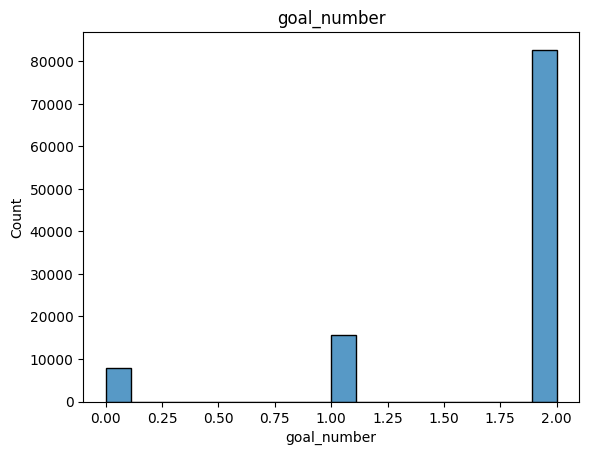

In [16]:
# train_dataの特長量のヒストグラムを表示する
features = train_data.columns
for feature in features:
    plt.figure()
    sns.histplot(train_data[feature])
    # タイトルは日本語でも表示できるようにする
    plt.title(feature)
    plt.show()


In [17]:
# train_dataを7:3でテストデータに分ける
from sklearn.model_selection import train_test_split
# テストデータと学習データ分割
train_total,test_total = train_test_split(train_data, test_size=0.3, random_state=42)

In [18]:
y = train_total['goal_number']
train_total.drop('goal_number', axis=1, inplace=True)

In [19]:
y_test_true = test_total['goal_number']
test_total.drop('goal_number', axis=1, inplace=True)

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(train_total, y, test_size=0.2, random_state=42)

train data length 59485
valid data length 14872
test data length 31868
train data length 59485
valid data length 14872
test data length 31868


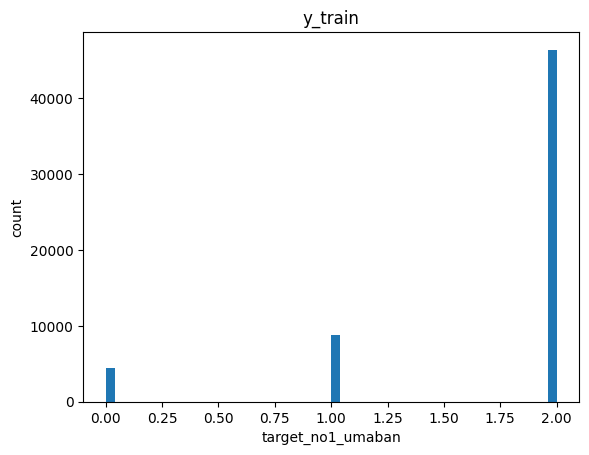

23492     2
104460    1
12954     0
43026     2
94480     1
         ..
26889     2
105887    2
27260     2
81390     1
23682     2
Name: goal_number, Length: 59485, dtype: int64


In [21]:
# 学習データ、検証データ、テストデータの割り振りが完了したので、それぞれのデータ数を表示する
print("train data length {}".format(len(X_train)))
print("valid data length {}".format(len(X_valid)))
print("test data length {}".format(len(test_total)))
# 回答データについても、同様にデータ数を表示する
print("train data length {}".format(len(y_train)))
print("valid data length {}".format(len(y_valid)))
print("test data length {}".format(len(y_test_true)))

# 回答データのヒストグラムを表示する
# 横軸をすべての番号で表示する
f, (ax) = plt.subplots()
ax.hist(y_train, bins=50)
ax.set_title('y_train')
ax.set_xlabel('target_no1_umaban')
ax.set_ylabel('count')

plt.show()

print(y_train)


In [ ]:
import lightgbm as lgb
from sklearn.utils.class_weight import compute_sample_weight
dtrain = lgb.Dataset(X_train, label=y_train)  # 学習用
dvalid = lgb.Dataset(X_valid, label=y_valid)  # early_stopping用
# precisionの向上には重みづけが有効
# dtrain = lgb.Dataset(X_train, label=y_train, weight=compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
# dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)
# https://qiita.com/Dixhom/items/fd78f461d038798a7e2e
# fobj=fobjというハイパラもある？
print(compute_sample_weight(class_weight='balanced', y=y_train).astype('float32'))
print(np.ones(len(X_valid)).astype('float32'))

[0.4274914 2.2684286 4.54674   ... 0.4274914 2.2684286 0.4274914]
[1. 1. 1. ... 1. 1. 1.]


In [23]:
# feature_names = dtrain.feature_name
# clean_feature_names = [name.replace(' ', '_').replace(':', '_').replace('"', '_').replace("'", '_') for name in feature_names]
# # データセットに新しい特徴量名を設定
# dtrain.feature_name = clean_feature_names
# dvalid.feature_name = clean_feature_names

In [24]:
learning_rate = 0.01
num_leaves = 15
max_depth = 12
min_data_in_leaf = 10
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    # 'metric': 'rmse',
    'metric': 'multi_logloss',
    # 'metric': 'auc', # AUCでもいい
    'num_class': 3, # クラスの数
    
    # "seed":[31],
    # 'random_state': [42],
    # 'lambda_l2':5, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
    # #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
    # 'verbose' : [-1],
    "num_iterations":100, # early stopping で止まるため大きめに設定しておけばよい
    
    # 以下のパラメータを調整対象とする
    "learning_rate": learning_rate, #学習率
    "num_leaves":num_leaves,
    "max_depth":max_depth,
    "min_data_in_leaf":min_data_in_leaf,
    # "bagging_fraction":[0.8],
    # "bagging_freq":[1],
}

In [25]:
#学習
# 以下を参考にearly stoppingを10で設定
# https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4
# ステップごとの処理結果の保存コールバックで実施するよう仕様変更更
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.record_evaluation.html

verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
evaluation_results = {} 
import time
starttime = time.time()
# best_params = gcv.best_params_
best_params = params

gbm = lgb.train(best_params,
                dtrain,
                #categorical_feature=categorical_features,
                valid_sets=[dtrain,dvalid],
                valid_names=['train', 'valid'],     
                num_boost_round = 100,
                # feval=acquire_custom_metircs, 
                callbacks=[lgb.early_stopping(stopping_rounds=100, 
                                verbose=True), # early_stopping用コールバック関数
                           lgb.log_evaluation(verbose_eval),
                           lgb.record_evaluation(evaluation_results)] # コマンドライン出力用コールバック関数
                )

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3617
[LightGBM] [Info] Number of data points in the train set: 59485, number of used features: 33


/home/hayato/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -2.613023
[LightGBM] [Info] Start training from score -1.917700
[LightGBM] [Info] Start training from score -0.248791
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	train's multi_logloss: 0.534167	valid's multi_logloss: 0.542819


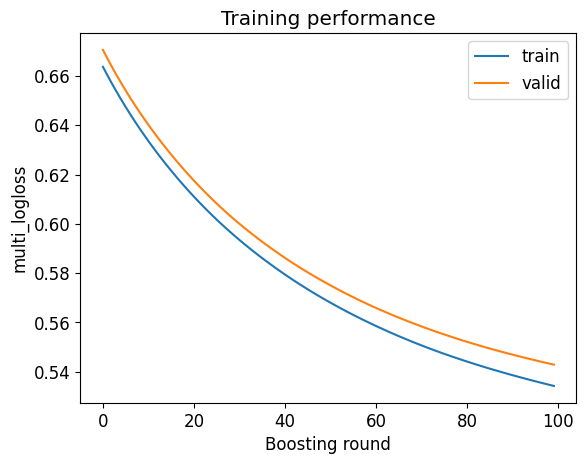

In [26]:
# 学習過程の可視化
plt.rcParams["font.size"] = 12
plt.plot(evaluation_results['train']['multi_logloss'], label='train')
plt.plot(evaluation_results['valid']['multi_logloss'], label='valid')
plt.ylabel('multi_logloss')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
plt.show()

In [27]:
# 検証データを推論
y_pred_train = gbm.predict(X_valid)
y_pred_train = pd.DataFrame(y_pred_train)
print(y_pred_train.head())
print(y_pred_train[0])

          0         1         2
0  0.025651  0.051041  0.923308
1  0.028079  0.067305  0.904616
2  0.081094  0.298419  0.620487
3  0.025651  0.051041  0.923308
4  0.159178  0.272223  0.568599
0        0.025651
1        0.028079
2        0.081094
3        0.025651
4        0.159178
           ...   
14867    0.026493
14868    0.056124
14869    0.025651
14870    0.073158
14871    0.025651
Name: 0, Length: 14872, dtype: float64


In [28]:
y_pred_int = y_pred_train.idxmax(axis=1)
# y_pred_int = np.argmax(y_pred_train.values, axis=1)
# y_pred_int = y_pred_train.astype(int)
y_pred_int

0        2
1        2
2        2
3        2
4        2
        ..
14867    2
14868    2
14869    2
14870    2
14871    2
Length: 14872, dtype: int64

In [29]:
# yvalidのラベルの配列をy_pred_trainから取得して正解のラベルの予測確率値を取得
y_pred_correct = []
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_correct.append(y_probability)

# ラベル無視して最大確率のみを抽出した配列。
y_pred_correct

# ラベルごとの確率値を取得
# 0~10のラベルごとの確率値を取得
y_pred_categorical = [[] for _ in range(19)]
for i, y_val in enumerate(y_valid):
    # 行指定で各確率値を取得
    y_pred = y_pred_train.iloc[i]
    y_probability = y_pred[y_val]
    y_pred_categorical[y_val].append(y_probability)

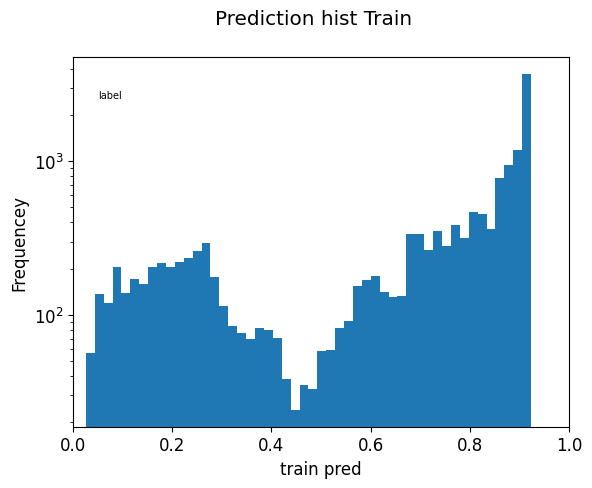

In [30]:
# 正解ラベルの確率値のヒストグラム作成
f, (ax) = plt.subplots()
f.suptitle('Prediction hist Train')

bins = 50

ax.hist(y_pred_correct, bins = bins)

plt.xlabel('train pred')
plt.ylabel('Frequencey')
plt.xlim((0, 1))
plt.yscale('log')
plt.text(0.05, 0.89, 'label',transform = ax.transAxes, fontsize = 7)
plt.show();

# 確率が低い（つまり他のジャンルと分類される）ものが多い。理想は左画はほぼなくて、右に寄ったグラフが作成できること。

In [31]:
# for i, y_pred_category in enumerate(y_pred_categorical):
#     f, (ax) = plt.subplots()
#     f.suptitle('Prediction hist Train')

#     bins = 50

#     ax.hist(y_pred_category, bins = bins)

#     plt.xlabel('train pred')
#     plt.ylabel('Frequencey')
#     plt.xlim((0, 1))
#     plt.yscale('log')
#     plt.text(0.05, 0.9, 'labele is :{}'.format(i),transform = ax.transAxes, fontsize = 14)
#     plt.show();

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36062 (\N{CJK UNIFIED IDEOGRAPH-8CDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21213 (\N{CJK UNIFIED IDEOGRAPH-52DD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 21033 (\N{CJK UNIFIED IDEOGRAPH-5229}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hayato/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35079 (\N{CJK UNIFIED IDEOGRAPH-8907}) missing from current font.
  fig.c

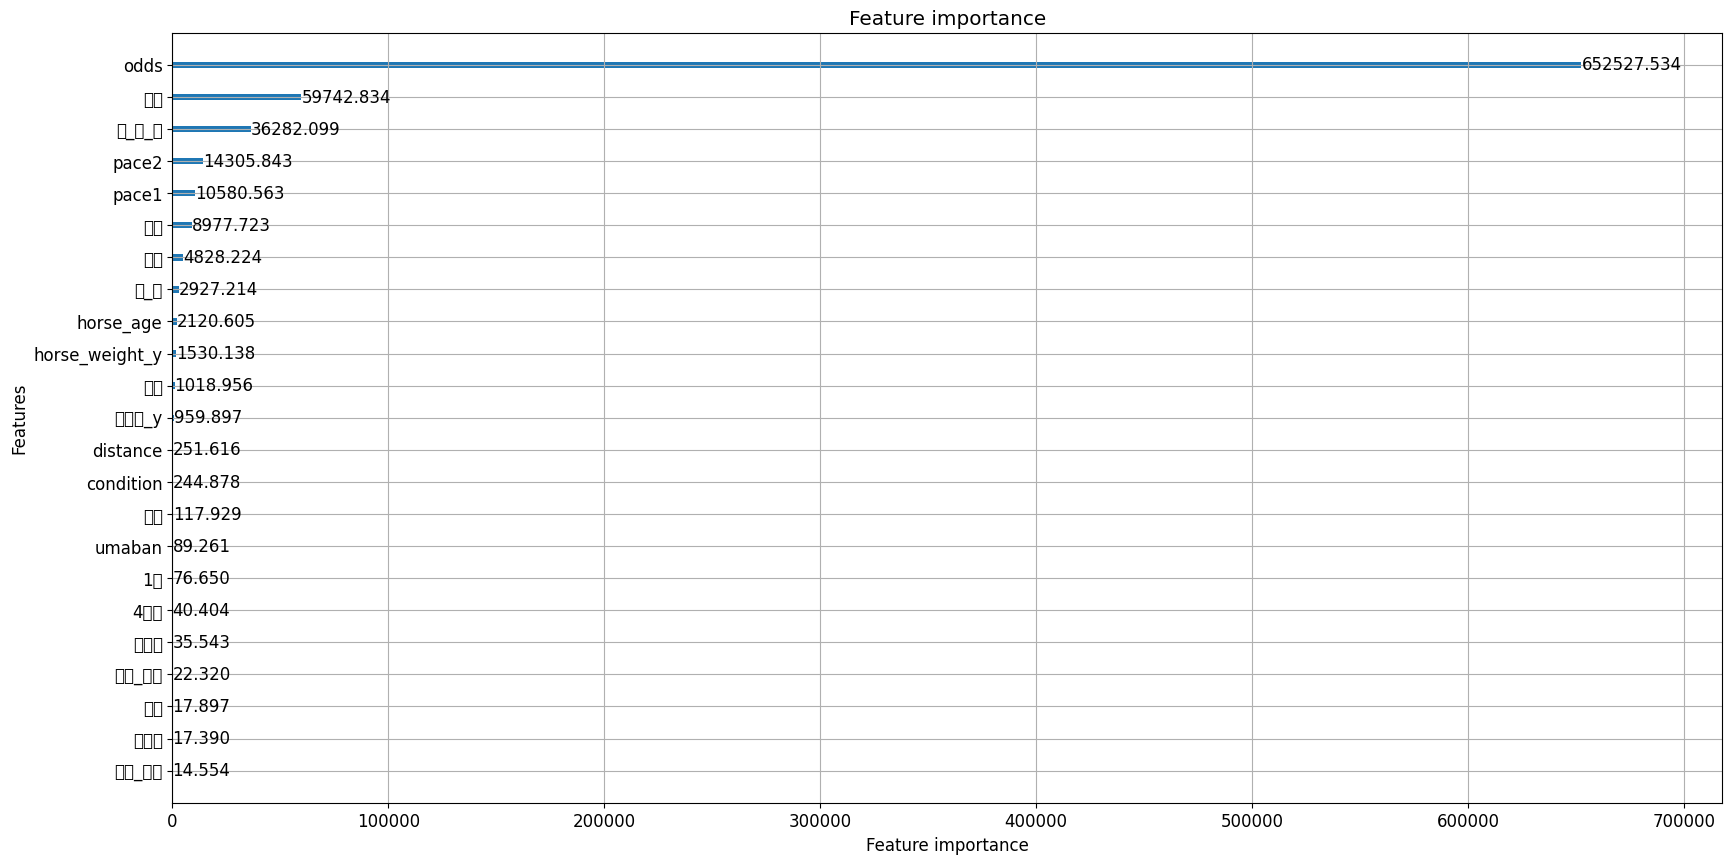

In [32]:
# 4. feature importanceが確認できる
# 特徴点（特徴量）の寄与率を明示化する。特徴点抽出
# 学習後、以下のURLを参考に寄与率を算出させてみる。
# https://qiita.com/ku_a_i/items/74241c84cda8c7327277
lgb.plot_importance(gbm, figsize=(20,10),importance_type='gain')

f1_score=0.7814012910166757


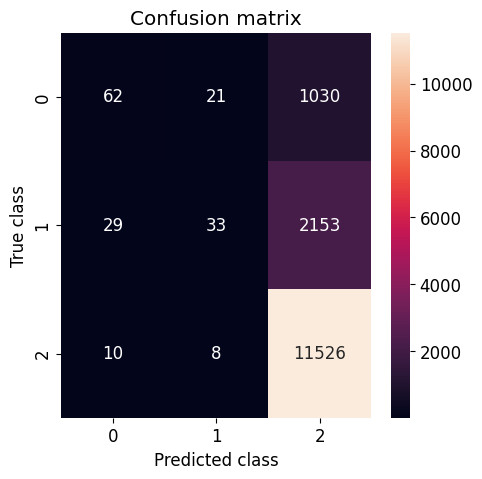

In [33]:
import os
import datetime
from sklearn import metrics
Dicision_threshould = 0.5

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "LightGBM"+ "_" + str(Dicision_threshould)+ '.png'


if not os.path.isdir(path):
   os.mkdir(path)


# スコア(RMSE)算出
# y_pred_int = np.where(y_pred_train > Dicision_threshould, 1, 0)
y_pred_int = y_pred_train.idxmax(axis=1)

f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

label = ["一位","二位か三位","四位以降"]

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()

f1_score=0.7814012910166757


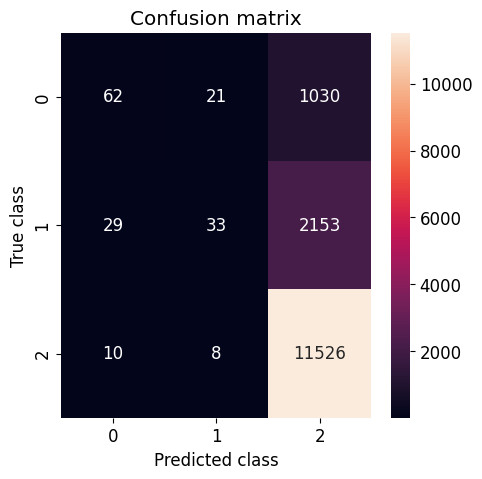

In [34]:
import os
import datetime
from sklearn import metrics

Dicision_threshould = 0.7

path = "result/" 
now = datetime.datetime.now()
filename = path + now.strftime('%Y%m%d_%H%M%S') + "_"+ "Ansamble"+ "_" + str(Dicision_threshould)+ '.png'

# y_pred_train_ansamble = (y_pred_train_rf + y_pred_train) / 2.0


# スコア(RMSE)算出

# y_pred_train_ansamble = y_pred_int * 0.8 + y_pred_train_rf * 0.2
# y_pred_int = y_pred_train_ansamble.idmax(axis=1)


f1_score = metrics.f1_score(y_true=y_valid, y_pred=y_pred_int, average="micro")
print(f'f1_score={f1_score}')

plt.rcParams["font.size"] = 12

import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
   roc_curve, recall_score, classification_report, f1_score,
   precision_recall_fscore_support)
conf_matrix = confusion_matrix(y_valid, y_pred_int)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.savefig(filename)
plt.show()


inference test data and compare with test correct data
              precision    recall  f1-score   support

           0       0.69      0.06      0.12      2348
           1       0.59      0.02      0.03      4716
           2       0.79      1.00      0.88     24804

    accuracy                           0.78     31868
   macro avg       0.69      0.36      0.34     31868
weighted avg       0.75      0.78      0.70     31868



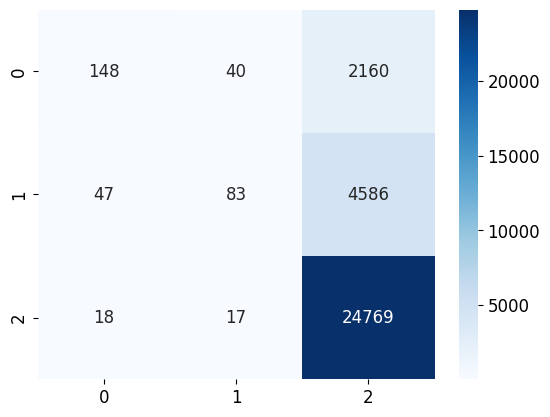

In [35]:
########### inference test data and compare with test correct data ###########
print("inference test data and compare with test correct data")
# ワンホットベクトル化しているのでテストのほうではカラムがないやつもあり数がずれるのでこの引数が必要。
y_pred = gbm.predict(test_total)
y_pred = pd.DataFrame(y_pred)
y_pred_submit = y_pred.idxmax(axis=1)

# テストデータの推論結果と、正解データを比較する
from sklearn.metrics import classification_report
print(classification_report(y_test_true, y_pred_submit))
# confusion matrixを表示する
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_true, y_pred_submit)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.show()

# precisionが正解率。0と1のprecisionが高いと使い物になってくる。なぜなら高い順位の馬を推論できているから

In [36]:
# ランキング学習での推論
# step1 クエリを作成する
# ランキング学習のためのクエリを作成

# ============データ情報整理================
# X_train: 学習用データ。クエリ必要
# X_valid: 検証データ。クエリ必要
# y_train: 学習用データの答え
# y_valid: 検証データの答え
# test_total: テストデータ。クエリ不要
# y_test_true: テストデータの答え
# ========================================
# ランキング学習用のtrain dataを7:3で分割。この際データがばらばらに混ざってしまうので上から7割を学習データ、残りをテストデータとする
train_ranking = train_data_for_ranking[:int(len(train_data_for_ranking)*0.7)]
test_ranking = train_data_for_ranking[int(len(train_data_for_ranking)*0.7):]
# train_rankingを7:3で分割。この際データがばらばらに混ざってしまうので上から7割を学習データ、残りをテストデータとする
train_ranking = train_ranking[:int(len(train_ranking)*0.7)]
valid_ranking = train_ranking[int(len(train_ranking)*0.7):]

def create_query(df, name='train'):
    # データの先頭を表示して確認
    # print("DataFrame head:")
    # print(df.head())


    # groupbyを使用してdate, race_name, place, number_of_horses, distanceごとにカウント
    race_place_counts = df.groupby(['race_id']).size().reset_index(name='horse_count')

    # date列を昇順にソート
    # race_place_counts = race_place_counts.sort_values(by='date', ascending=False)

    # 各レースの馬の数をリストに保存
    horse_counts_list = race_place_counts['horse_count'].tolist()

    # 結果の表示
    print("\nResulting list of horse counts per race (sorted by date):")
    print(horse_counts_list)

    # 特徴量データを日付の古い順にソート
    # sorted_df = df.sort_values(by='date', ascending=True)

    # ソートデータの保存
    df.to_csv("sorted_{}_data.csv".format(name), index=False)
    # date, race_name, place, number_of_horses, distanceのユニークな組み合わせを表示して確認
    print("\nUnique combinations of date, race_name, place, number_of_horses, distance:")
    # 上から100データを表示
    print(df[['course_len', 'weather', 'race_type', 'ground_state', 'date']].head(100))
    return horse_counts_list, df

# trainデータのクエリを作成
train_query, sorted_train_data = create_query(train_ranking,"train")
# validデータのクエリを作成
valid_query, sorted_valid_data = create_query(valid_ranking,"valid")





Resulting list of horse counts per race (sorted by date):
[16, 24, 27, 26, 20, 28, 32, 26, 17, 18, 29, 28, 16, 28, 32, 28, 12, 31, 22, 22, 20, 27, 30, 27, 18, 28, 30, 27, 27, 24, 30, 26, 28, 16, 32, 22, 28, 22, 27, 32, 23, 25, 26, 22, 28, 27, 28, 27, 28, 22, 32, 27, 20, 31, 26, 25, 18, 28, 27, 28, 28, 28, 29, 28, 14, 28, 23, 28, 22, 22, 28, 32, 18, 28, 23, 27, 26, 32, 24, 25, 18, 21, 27, 31, 14, 24, 28, 28, 20, 27, 28, 14, 22, 18, 28, 26, 24, 28, 32, 28, 22, 28, 32, 28, 27, 32, 28, 23, 22, 24, 26, 28, 18, 24, 32, 17, 27, 28, 30, 26, 22, 10, 24, 26, 25, 28, 27, 28, 27, 24, 24, 27, 17, 27, 22, 26, 10, 29, 23, 27, 28, 24, 30, 24, 16, 27, 31, 28, 26, 24, 31, 27, 31, 27, 20, 28, 21, 18, 28, 31, 28, 32, 28, 28, 26, 24, 28, 28, 32, 27, 24, 30, 21, 28, 17, 22, 16, 26, 26, 24, 32, 28, 24, 32, 21, 31, 21, 22, 31, 28, 31, 24, 32, 27, 22, 24, 27, 24, 27, 23, 22, 18, 30, 28, 28, 31, 24, 24, 21, 25, 24, 32, 22, 26, 31, 30, 18, 20, 32, 21, 9, 22, 22, 26, 16, 25, 31, 23, 32, 18, 24, 27, 12, 20, 17, 2

In [37]:
# クエリの数の合計を確認
print("Number of queries in train data: {}".format(sum(train_query)))
print("Number of queries in valid data: {}".format(sum(valid_query)))
print("Total number of queries: {}".format(len(train_query) + len(valid_query)))
print("Number of rows in train data: {}".format(len(sorted_train_data)))
print("Number of rows in valid data: {}".format(len(sorted_valid_data)))
print("Total number of rows: {}".format(len(sorted_train_data) + len(sorted_valid_data)))


Number of queries in train data: 52049
Number of queries in valid data: 15615
Total number of queries: 2554
Number of rows in train data: 52049
Number of rows in valid data: 15615
Total number of rows: 67664


In [38]:
# クエリを取得したので前処理をかける
X_sorted_train_data = preprocess(sorted_train_data,is_ranking=True)
X_sorted_valid_data = preprocess(sorted_valid_data,is_ranking=True)
test_ranking = preprocess(test_ranking,is_ranking=True)

Index(['着順', '枠番', '馬番', '馬名', '性齢', '斤量', '騎手_x', 'タイム_x', '着差_x', '単勝', '人気',
       '馬体重_x', '調教師', 'course_len', 'weather', 'race_type', 'ground_state',
       'date', 'horse_id', 'jockey_id', 'race_id', '日付', '開催', '天 気', 'R',
       'レース名', '映 像', '頭 数', '枠 番', '馬 番', 'オ ッ ズ', '人 気', '着 順', '騎手_y',
       '斤 量', '距離', '馬 場', '馬場 指数', 'タイム_y', '着差_y', 'ﾀｲﾑ 指数', '通過', 'ペース',
       '上り', '馬体重_y', '厩舎 ｺﾒﾝﾄ', '備考', '勝ち馬 (2着馬)', '賞金', '年度', '1着', '2着',
       '3着', '4着〜', '騎乗 回数', '重賞 出走', '重賞 勝利', '勝率', '連対率', '複勝率',
       'goal_number', 'goal_number_replace', 'horse_sex', 'horse_age',
       'horse_weight', 'weight_change', 'handi', 'distance', 'condition',
       'umaban', 'odds', 'pace1', 'pace2', 'horse_weight_y',
       'weight_change_y'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52049 entries, 0 to 52048
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   distan

/tmp/ipykernel_14653/2102171454.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_14653/2102171454.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[column] = le.fit_transform(train_data[column])
/tmp/ipykernel_14653/2102171454.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Index(['着順', '枠番', '馬番', '馬名', '性齢', '斤量', '騎手_x', 'タイム_x', '着差_x', '単勝', '人気',
       '馬体重_x', '調教師', 'course_len', 'weather', 'race_type', 'ground_state',
       'date', 'horse_id', 'jockey_id', 'race_id', '日付', '開催', '天 気', 'R',
       'レース名', '映 像', '頭 数', '枠 番', '馬 番', 'オ ッ ズ', '人 気', '着 順', '騎手_y',
       '斤 量', '距離', '馬 場', '馬場 指数', 'タイム_y', '着差_y', 'ﾀｲﾑ 指数', '通過', 'ペース',
       '上り', '馬体重_y', '厩舎 ｺﾒﾝﾄ', '備考', '勝ち馬 (2着馬)', '賞金', '年度', '1着', '2着',
       '3着', '4着〜', '騎乗 回数', '重賞 出走', '重賞 勝利', '勝率', '連対率', '複勝率',
       'goal_number', 'goal_number_replace', 'horse_sex', 'horse_age',
       'horse_weight', 'weight_change', 'handi', 'distance', 'condition',
       'umaban', 'odds', 'pace1', 'pace2', 'horse_weight_y',
       'weight_change_y'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31868 entries, 74357 to 106224
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   d

/tmp/ipykernel_14653/2102171454.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['odds'] = train_data['単勝'].apply(lambda x: float(x))
/tmp/ipykernel_14653/2102171454.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['タイム_y'] = train_data['タイム_y'].astype(str).apply(
/tmp/ipykernel_14653/2102171454.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [39]:
# うまく目的変数の変換ができないので、現状のデータを見てみる
# X_sorted_train_data.to_csv("X_sorted_train_data.csv", index=False)

In [40]:
# X_sorted_train_dataにgoal_number_replaceを追加してcsvに保存する
# X_sorted_train_data.to_csv("X_sorted_train_data_add_goal_number.csv", index=False)

In [41]:
# # goal numberをスコア化
# # ランキング学習の場合は1位が30、2位が28、3位が26、残りは0の着順関連度に変換する。
# X_sorted_valid_data['goal_number_replace'] = X_sorted_valid_data['goal_number'].replace([1], 30)
# X_sorted_valid_data['goal_number_replace'] = X_sorted_valid_data['goal_number'].replace([2], 28)
# X_sorted_valid_data['goal_number_replace'] = X_sorted_valid_data['goal_number'].replace([3], 26)
# X_sorted_valid_data['goal_number_replace'] = X_sorted_valid_data['goal_number'].replace([4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], 0)

In [42]:
# # goal numberをスコア化
# # ランキング学習の場合は1位が30、2位が28、3位が26、残りは0の着順関連度に変換する。
# test_ranking['goal_number_replace'] = test_ranking['goal_number'].replace([1], 30)
# test_ranking['goal_number_replace'] = test_ranking['goal_number'].replace([2], 28)
# test_ranking['goal_number_replace'] = test_ranking['goal_number'].replace([3], 26)
# test_ranking['goal_number_replace'] = test_ranking['goal_number'].replace([4,5,6,7,8,9,10,11,12,13,14,15,16,17,18], 0)

In [43]:
# 1. 目的変数goal_number_replaceを確保
# 2. 実際のgoal_numberを確保
# 3. goal_number_replaceを削除
# 4. goal_numberを削除
# 1========================================================
y_train_ranking = X_sorted_train_data['goal_number_replace']
y_valid_ranking = X_sorted_valid_data['goal_number_replace']
y_test_true_ranking = test_ranking['goal_number_replace']
# 2========================================================
y_train_ranking_goal = X_sorted_train_data['goal_number']
y_valid_ranking_goal = X_sorted_valid_data['goal_number']
y_test_true_ranking_goal = test_ranking['goal_number']
# 3========================================================
X_sorted_train_data = X_sorted_train_data.drop('goal_number', axis=1)
X_sorted_valid_data = X_sorted_valid_data.drop('goal_number', axis=1)
test_ranking = test_ranking.drop('goal_number', axis=1)
# 4========================================================
X_sorted_train_data = X_sorted_train_data.drop('goal_number_replace', axis=1)
X_sorted_valid_data = X_sorted_valid_data.drop('goal_number_replace', axis=1)
test_ranking = test_ranking.drop('goal_number_replace', axis=1)


In [44]:
# 学習データ
X_sorted_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52049 entries, 0 to 52048
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   distance         52049 non-null  int64  
 1   condition        52049 non-null  int64  
 2   umaban           52049 non-null  int64  
 3   horse_age        52049 non-null  int64  
 4   horse_sex        52049 non-null  int64  
 5   handi            52049 non-null  int64  
 6   odds             52049 non-null  float64
 7   天 気              52049 non-null  int64  
 8   頭 数              52044 non-null  float64
 9   枠番               52049 non-null  int64  
 10  馬番               52049 non-null  int64  
 11  オ ッ ズ            51459 non-null  float64
 12  人気               51836 non-null  float64
 13  斤量               52049 non-null  float64
 14  距離               52049 non-null  int64  
 15  馬 場              52049 non-null  int64  
 16  タイム_y            50703 non-null  float64
 17  pace1       

In [45]:
# 検証データ
X_sorted_valid_data.info()
# 目的変数になってないか確認するためcsvで保存する
X_sorted_train_data.to_csv("X_sorted_train_data_data_check.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15615 entries, 36434 to 52048
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   distance         15615 non-null  int64  
 1   condition        15615 non-null  int64  
 2   umaban           15615 non-null  int64  
 3   horse_age        15615 non-null  int64  
 4   horse_sex        15615 non-null  int64  
 5   handi            15615 non-null  int64  
 6   odds             15615 non-null  float64
 7   天 気              15615 non-null  int64  
 8   頭 数              15612 non-null  float64
 9   枠番               15615 non-null  int64  
 10  馬番               15615 non-null  int64  
 11  オ ッ ズ            15465 non-null  float64
 12  人気               15564 non-null  float64
 13  斤量               15615 non-null  float64
 14  距離               15615 non-null  int64  
 15  馬 場              15615 non-null  int64  
 16  タイム_y            15270 non-null  float64
 17  pace1   

In [ ]:
# 学習データの答え
print(y_train_ranking.head())
y_train_ranking.describe()

0    7
1    7
2    3
3    3
4    1
Name: goal_number_replace, dtype: int64


count    52049.000000
mean         0.817576
std          1.928074
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: goal_number_replace, dtype: float64

In [47]:
print(y_train_ranking_goal.head())
y_train_ranking_goal.describe()

0    1
1    1
2    2
3    2
4    3
Name: goal_number, dtype: int64


count    52049.000000
mean         8.325770
std          9.789453
min          1.000000
25%          4.000000
50%          7.000000
75%         11.000000
max        100.000000
Name: goal_number, dtype: float64

In [48]:
# 検証データの答え
print(y_valid_ranking.head())
y_valid_ranking.describe()

36434    0
36435    0
36436    0
36437    0
36438    7
Name: goal_number_replace, dtype: int64


count    15615.000000
mean         0.797438
std          1.907464
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: goal_number_replace, dtype: float64

In [49]:
# テストデータ
test_ranking.describe()

,distance,condition,umaban,horse_age,horse_sex,handi,odds,天 気,頭 数,枠番,...,1着,2着,3着,4着〜,騎乗 回数,重賞 出走,重賞 勝利,勝率,連対率,複勝率
count,31868.000000,31868.000000,31868.000000,31868.000000,31868.000000,31868.000000,31868.000000,31868.000000,31862.000000,31868.000000,...,31868.000000,31868.000000,31868.000000,31868.000000,31868.000000,31868.000000,31868.000000,31868.000000,31868.000000,31868.000000
mean,1660.847872,0.510104,7.566085,3.744163,1.518985,55.895663,68.693291,2.288157,13.753782,4.795029,...,625.144628,609.751538,591.985628,5508.560374,7335.442168,348.638697,27.273691,7.264199,14.487900,21.684878
std,414.313116,0.551822,4.383919,1.339705,0.579769,1.757510,103.800687,0.696089,2.887996,2.277781,...,776.905981,676.849795,615.626613,4746.152158,6583.869375,440.431309,55.344311,3.700827,6.215188,8.001794
min,1000.000000,0.000000,1.000000,2.000000,0.000000,49.000000,1.100000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1400.000000,0.000000,4.000000,3.000000,1.000000,55.000000,7.700000,2.000000,12.000000,3.000000,...,104.000000,103.000000,116.000000,1748.000000,2059.000000,29.000000,1.000000,4.900000,10.100000,15.300000
50%,1700.000000,0.000000,7.000000,3.000000,2.000000,56.000000,24.200000,2.000000,14.000000,5.000000,...,405.000000,403.000000,419.000000,3537.000000,4790.000000,178.000000,10.000000,6.600000,13.200000,19.800000
75%,1800.000000,1.000000,11.000000,4.000000,2.000000,57.000000,83.900000,3.000000,16.000000,7.000000,...,923.000000,897.000000,908.000000,8280.000000,11223.000000,520.000000,28.000000,8.600000,17.500000,26.300000
max,3930.000000,2.000000,18.000000,12.000000,2.000000,62.000000,956.300000,6.000000,23.000000,8.000000,...,4559.000000,3451.000000,2772.000000,18808.000000,24936.000000,2047.000000,363.000000,50.000000,100.000000,100.000000


In [50]:
# テストデータの答え
print(y_test_true_ranking.head())
y_test_true_ranking.describe()

74357    0
74358    0
74359    0
74360    0
74361    0
Name: goal_number_replace, dtype: int64


count    31868.000000
mean         0.818250
std          1.927477
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          7.000000
Name: goal_number_replace, dtype: float64

In [51]:
# クエリの合計とデータの合計が一致しているか確認
print("Number of queries in train data: {}".format(sum(train_query)))
print("Number of queries in valid data: {}".format(sum(valid_query)))
# y_train_rankingの数とX_sorted_train_dataの数が一致しているか確認
print("y_train_ranking length {}".format(len(y_train_ranking)))
print("Number of rows in train data: {}".format(len(X_sorted_train_data)))
print("Number of rows in valid data: {}".format(len(X_sorted_valid_data)))
print("Total number of rows: {}".format(len(X_sorted_train_data) + len(X_sorted_valid_data)))

Number of queries in train data: 52049
Number of queries in valid data: 15615
y_train_ranking length 52049
Number of rows in train data: 52049
Number of rows in valid data: 15615
Total number of rows: 67664


In [52]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
from sklearn.metrics import ndcg_score

# データの準備
# X_sorted_train_data, y_train_ranking, train_query
# X_sorted_valid_data, y_valid_ranking, valid_query

# ランキング学習
model = lgb.LGBMRanker(
    random_state=42,
    objective='lambdarank',
    metric='ndcg',
    n_estimators=5000,              # 決定木の個数(default:100) 5000のほうが10000より高い
    learning_rate=0.01,            # 学習率(default:0.1)
    num_leaves=21,                 # 決定木にある分岐の個数(default:31)
    max_depth=-1,                  # 決定木の深さの最大値(default:-1)
    # feature_fraction=0.8,
    # bagging_fraction=0.8,
    # bagging_freq=10,
    # lambda_l1=0.1,
    # lambda_l2=0.1,
    # min_split_gain=0.1,
    # min_child_weight=0.1
)

# モデルの学習
model.fit(
    X_sorted_train_data,
    y_train_ranking,
    group=train_query,
    eval_set=[(X_sorted_valid_data, y_valid_ranking)],
    eval_group=[valid_query],
    eval_at=[1, 2, 3],
    eval_metric='ndcg',
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3524
[LightGBM] [Info] Number of data points in the train set: 52049, number of used features: 33
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


LGBMRanker(learning_rate=0.01, metric='ndcg', n_estimators=5000, num_leaves=21,
           objective='lambdarank', random_state=42)

In [53]:
# from sklearn.model_selection import GridSearchCV, KFold
# # パラメータグリッドの設定
# param_grid = {
#     'num_leaves': [15],
#     'learning_rate': [0.01],
#     'n_estimators': [5000],
#     'feature_fraction': [0.8],
#     # 'bagging_fraction': [0.8,  1.0],
#     # 'bagging_freq': [0, 10],
#     # 'lambda_l1': [0.0, 0.1],
#     # 'lambda_l2': [0.0, 0.1],
#     'min_split_gain': [0.1],
#     'min_child_weight': [0.1]
# }

# # LGBMRankerのインスタンスを作成
# model = lgb.LGBMRanker(
#     boosting_type='gbdt',
#     objective='lambdarank',
#     metric='ndcg',
#     random_state=42,
#     n_jobs=-1
# )

# # グリッドサーチの設定
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring='neg_mean_squared_error',  # 適切なスコアリング関数を選択
#     cv=KFold(n_splits=2, shuffle=True, random_state=42),
#     verbose=1,
#     n_jobs=-1
# )

# # クエリを分割に応じて調整する関数
# def adjust_query_for_split(train_query, train_index):
#     adjusted_query = []
#     start_idx = 0
#     for q in train_query:
#         end_idx = start_idx + q
#         if np.any(np.isin(train_index, range(start_idx, end_idx))):
#             adjusted_query.append(np.sum(np.isin(train_index, range(start_idx, end_idx))))
#         start_idx = end_idx
#     return adjusted_query

# # モデルの学習
# for train_index, test_index in grid_search.cv.split(X_sorted_train_data):
#     X_train, X_test = X_sorted_train_data.iloc[train_index], X_sorted_train_data.iloc[test_index]
#     y_train, y_test = y_train_ranking.iloc[train_index], y_train_ranking.iloc[test_index]
#     adjusted_train_query = adjust_query_for_split(train_query, train_index)
#     grid_search.fit(X_train, y_train, group=adjusted_train_query)

# # 最適なパラメータの表示
# print("Best parameters found: ", grid_search.best_params_)
# print("Best score: ", grid_search.best_score_)

# # 最適なモデルで予測
# model = grid_search.best_estimator_


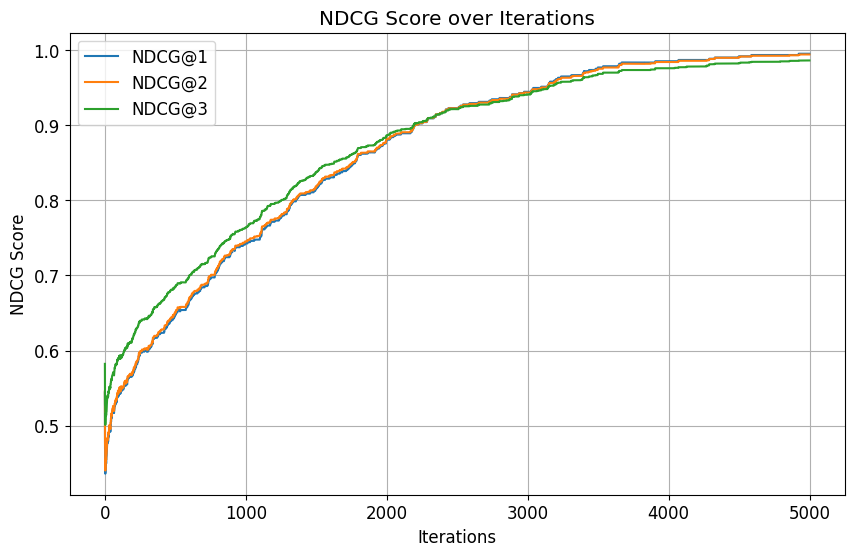

Best NDCG@1: 0.9949 in iteration: 0


In [54]:
# トレーニング結果の取得
evals_result = model.evals_result_

# NDCGスコアのプロット
# NDCGスコアは1になるほど予測モデルの性能が良いことを占める。1,3,5は上位何件の結果を反映するか。
plt.figure(figsize=(10, 6))
plt.plot(evals_result['valid_0']['ndcg@1'], label='NDCG@1')
plt.plot(evals_result['valid_0']['ndcg@2'], label='NDCG@2')
plt.plot(evals_result['valid_0']['ndcg@3'], label='NDCG@3')
plt.xlabel('Iterations')
plt.ylabel('NDCG Score')
plt.title('NDCG Score over Iterations')
plt.legend()
plt.grid(True)
plt.show()
# model.best_iteration_のNDCGを数値で出力
print("Best NDCG@1: {:.4f} in iteration: {}".format(evals_result['valid_0']['ndcg@1'][model.best_iteration_ - 1], model.best_iteration_))

In [55]:
#　テストデータで推論

prediction_test_ranking = model.predict(test_ranking, num_iteration=model.best_iteration_)

df_prediction_test_ranking = pd.DataFrame({
    "馬番号": test_ranking["umaban"],
    "予測スコア": prediction_test_ranking,
    "着順関連度": y_test_true_ranking,
    "着順": y_test_true_ranking_goal,
})
print(df_prediction_test_ranking)
# pandasをcsvに保存
train_path_result = train_path + "inference_result/"
if not os.path.isdir(train_path_result):
    os.mkdir(train_path_result)
df_prediction_test_ranking.to_csv(train_path_result + "prediction_test_ranking.csv", index=False)

        馬番号     予測スコア  着順関連度  着順
74357    10 -0.606835      0  12
74358    10 -0.606835      0  12
74359     6 -4.980139      0  13
74360     6 -4.972943      0  13
74361     8 -3.122458      0  14
...     ...       ...    ...  ..
106220    8 -5.320199      0  13
106221   15 -3.812219      0  14
106222   15 -3.879471      0  14
106223    1 -0.672339      0  15
106224    1 -0.672339      0  15

[31868 rows x 4 columns]


In [56]:
# 予測結果の評価
# 1位、2位、3位に対して予測するとどうなるのかを知りたかったが、どこまでが1レースの情報化の区切りを持ってないのでたぶんできない。
# ひとまず推論で確認する

In [57]:
# 特徴重要度の可視化
df_importance = pd.DataFrame({"columns": X_sorted_train_data.columns, "importance": model.feature_importances_})
df_importance.sort_values("importance", ascending=False, inplace=True)
print(df_importance)

            columns  importance
6              odds       10764
11            オ ッ ズ        7610
16            タイム_y        6386
20   horse_weight_y        5684
17            pace1        5673
19               上り        5672
22               賞金        5279
18            pace2        5268
2            umaban        4921
21  weight_change_y        3899
0          distance        3082
9                枠番        3056
26              4着〜        3036
12               人気        2766
5             handi        2691
8               頭 数        2674
30               勝率        2671
3         horse_age        2054
23               1着        1868
14               距離        1814
32              複勝率        1809
31              連対率        1750
28            重賞 出走        1586
29            重賞 勝利        1467
24               2着        1304
25               3着        1304
27            騎乗 回数        1072
7               天 気         757
1         condition         669
4         horse_sex         575
15      

In [58]:
# # import pandas as pd
# # import seaborn as sns
# # import matplotlib.pyplot as plt
# # import matplotlib.font_manager as fm
# # # 日本語フォントの設定
# # font_path = '/usr/share/fonts/truetype/ipafont-gothic/ipagp.ttf'  # フォントのパス
# # font_prop = fm.FontProperties(fname=font_path)
# # plt.rcParams['font.family'] = font_prop.get_name()

# grouped = df_prediction_test_ranking.groupby("着順")["予測スコア"].agg(['mean', 'std']).reset_index()
# unique_ranks = df_prediction_test_ranking["着順"].unique()

# for rank in unique_ranks:
#     plt.figure(figsize=(12, 6))
#     subset = df_prediction_test_ranking[df_prediction_test_ranking["着順"] == rank]
#     mean_score = subset["予測スコア"].mean()
#     std_score = subset["予測スコア"].std()
    
#     sns.histplot(subset["予測スコア"], bins=20, kde=True)
#     plt.axvline(mean_score, color='r', linestyle='--', label=f'average: {mean_score:.2f}')
#     plt.axvline(mean_score + std_score, color='g', linestyle='--', label=f'std: {std_score:.2f}')
#     plt.axvline(mean_score - std_score, color='g', linestyle='--')
    
#     plt.title(f"goul number: {rank} prediction score")
#     plt.xlabel("prediction score")
#     plt.ylabel("frequency")
#     plt.legend()
#     plt.show()

In [59]:
from pathlib import Path
import pandas as pd
import tqdm

# csvデータを1つずつ読み出し推論
p = Path(inference_data_path)
files = list(p.glob("*inference*.csv"))
count = 0
for file in tqdm.tqdm(files):
    # 読み込んだファイル名を出力
    print("=======予測ファイル名======== {}".format(file))
    inference_data = pd.read_csv(file, encoding='utf-8')
    # データの確認
    print(inference_data.info())

    # Unnamed: 0,class_list_in_raceを削除
    # inference_data = inference_data.drop(['Unnamed: 0',"class_list_in_race","date"], axis=1)
    # inference_data.info()

    #　=================real dataで推論=============================
    inference_data_answer = inference_data["goal_number"]
    inference_data = inference_data.drop("goal_number", axis=1)

    # 学習データとカラム名を統一する
    # 枠 番は枠番に変換する
    inference_data = inference_data.rename(columns={'枠 番':'枠番'})
    # 馬 番は馬番に変換する
    inference_data = inference_data.rename(columns={'馬 番':'馬番'})
    # 人 気は人気に変換する
    inference_data = inference_data.rename(columns={'人 気':'人気'})
    # 斤 量は斤量に変換する
    inference_data = inference_data.rename(columns={'斤 量':'斤量'})
    # タイムはタイム_yに変換する
    inference_data = inference_data.rename(columns={'タイム':'タイム_y'})

    # 学習データとの共通処理
    # タイム_yは1:34.0のような形式なので、秒に変換する
    # nanの場合は100に変換する
    # 'タイム_y'列の値を文字列に変換し、NaN値を無視して処理を行う
    inference_data['タイム_y'] = inference_data['タイム_y'].astype(str).apply(
        lambda x: int(x.split(':')[0]) * 60 + float(x.split(':')[1]) if ':' in x else np.nan
    )

    # 'ペース'列の値を文字列に変換し、NaN値を無視して処理を行う
    inference_data['pace1'] = inference_data['ペース'].astype(str).apply(
        lambda x: float(x.split('-')[0]) if '-' in x else np.nan
    )
    inference_data['pace2'] = inference_data['ペース'].astype(str).apply(
        lambda x: float(x.split('-')[1]) if '-' in x else np.nan
    )

    # 馬体重_yは480(+2)のような形式なので、体重と増減を分ける
    # '馬体重'列の値を文字列に変換し、'計不'を'500(0)'に置き換える
    inference_data['馬体重'] = inference_data['馬体重'].astype(str).replace('計不', '500(0)')

    # 'horse_weight_y'列を作成し、'馬体重'列の値を処理
    inference_data['horse_weight_y'] = inference_data['馬体重'].apply(
        lambda x: int(x.split('(')[0]) if '(' in x else np.nan
    )

    # 'weight_change_y'列を作成し、'馬体重'列の値を処理
    inference_data['weight_change_y'] = inference_data['馬体重'].apply(
        lambda x: int(x.split('(')[1].replace(')', '')) if '(' in x else np.nan
    )

    # '連対率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    inference_data['連対率'] = inference_data['連対率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) else x
    )

    # '勝率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    inference_data['勝率'] = inference_data['勝率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) else x
    )

    # '複勝率'列の値を処理し、全角の'％'を半角の'%'に置き換えてからfloatに変換
    inference_data['複勝率'] = inference_data['複勝率'].apply(
        lambda x: float(x.replace('％', '')) if isinstance(x, str) else x
    )

    # inference_dataの特長量を設定する
    inference_data = inference_data[X_sorted_train_data.columns]

    # ラベルエンコーディングは前処理終了後
    # inference_dataの特長量のobject型は、LabelEncoderで数値に変換する
    # object型の特長量を確認する
    object_columns = inference_data.select_dtypes(include='object').columns
    object_columns
    for column in object_columns:
        le = LabelEncoder()
        inference_data[column] = le.fit_transform(inference_data[column])

    # 対数変換実施
    # inference_data = log_transform(inference_data)

    # 標準化実施
    # inference_data = standard_scaler(inference_data)

    # モデル予測
    prediction_inference_ranking = model.predict(inference_data, num_iteration=model.best_iteration_)

    # データフレームを作成
    df_prediction_test_ranking = pd.DataFrame({
        "馬番号": inference_data["umaban"],
        "予測スコア": prediction_inference_ranking,
        "odds": inference_data["odds"],
        "着順": inference_data_answer,
    })

    # 予測スコアの高い順にソート
    df_prediction_test_ranking = df_prediction_test_ranking.sort_values(by="予測スコア", ascending=False)

    # 予測順位を計算
    df_prediction_test_ranking["予測順位"] = df_prediction_test_ranking["予測スコア"].rank(ascending=False, method='first').astype(int)

    # インデックスをリセット
    df_prediction_test_ranking = df_prediction_test_ranking.reset_index(drop=True)

    # 結果を確認
    # print(df_prediction_test_ranking.head())
    # pandasをcsvに保存
    # inference_data_path + /inference_resultにディレクトリを作成し、csvを保存する
    inference_data_path_result = inference_data_path + "inference_result/"
    if not os.path.isdir(inference_data_path_result):
        os.mkdir(inference_data_path_result)

    # 読み込みファイルパスからファイル名だけを取得
    file_name = file.name

    saving_path = inference_data_path_result + "prediction_" +  str(file_name) + "_.csv"
    print("saving_path:{}".format(saving_path))
    df_prediction_test_ranking.to_csv(saving_path, index=False)
    count +=1
    # print(df_prediction_test_ranking)

  0%|          | 0/11 [00:00<?, ?it/s]

=======予測ファイル名======== /home/hayato/horse_inference/inference/2025050101/add_dynamic_data/updated_inference_data_202505010111.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 59 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          13 non-null     int64  
 1   date                0 non-null      float64
 2   race_name           13 non-null     object 
 3   place               13 non-null     object 
 4   class_list_in_race  13 non-null     object 
 5   number_of_horses    13 non-null     int64  
 6   distance            13 non-null     int64  
 7   condition           13 non-null     object 
 8   horse_name          13 non-null     object 
 9   umaban              13 non-null     int64  
 10  horse_age           13 non-null     int64  
 11  horse_sex           13 non-null     object 
 12  horse_weight        13 non-null     int64  
 13  weight_change       13 non-

 55%|█████▍    | 6/11 [00:00<00:00, 49.74it/s]

saving_path:/home/hayato/horse_inference/inference/2025050101/add_dynamic_data/inference_result/prediction_updated_inference_data_20250501014.csv_.csv
=======予測ファイル名======== /home/hayato/horse_inference/inference/2025050101/add_dynamic_data/updated_inference_data_20250501016.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 59 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          16 non-null     int64  
 1   date                0 non-null      float64
 2   race_name           16 non-null     object 
 3   place               16 non-null     object 
 4   class_list_in_race  16 non-null     object 
 5   number_of_horses    16 non-null     int64  
 6   distance            16 non-null     int64  
 7   condition           16 non-null     object 
 8   horse_name          16 non-null     object 
 9   umaban              16 non-null     int64  
 10  horse_age           16 n

100%|██████████| 11/11 [00:00<00:00, 51.74it/s]

saving_path:/home/hayato/horse_inference/inference/2025050101/add_dynamic_data/inference_result/prediction_updated_inference_data_202505010110.csv_.csv


In [61]:
# MLPでリストワイズアプローチ

# 特徴量と目的変数
target = '着順'  # 目的変数のカラム名
exclude_features = ['race_id', '着順']  # 除外するカラム
features = [col for col in train_data_mlp.columns if col not in exclude_features]

# レースごとにデータを分割
grouped = train_data_mlp.groupby('race_id')
X = [group[features].values for _, group in grouped]
y = [group[target].values for _, group in grouped]

# X、yのデータを確認
print(X[0])
print(y[0])


[[ 1.2000e+03  1.0000e+00  5.0000e+00  2.0000e+00  2.0000e+00  5.5000e+01
   1.2000e+00  2.0000e+00  1.4000e+01  5.0000e+00  5.0000e+00  3.8000e+00
   1.0000e+00  5.5000e+01  2.8000e+01  2.0000e+00  8.1800e+01  3.5400e+01
   3.4400e+01  3.3700e+01  4.5800e+02  2.0000e+00         nan  6.6100e+02
   5.5600e+02  5.4300e+02  3.9070e+03  5.6670e+03  2.7400e+02  2.3000e+01
   1.1700e+01  2.1500e+01  3.1100e+01  0.0000e+00]
 [ 1.2000e+03  1.0000e+00  5.0000e+00  2.0000e+00  2.0000e+00  5.5000e+01
   1.2000e+00  2.0000e+00  1.4000e+01  5.0000e+00  5.0000e+00  3.8000e+00
   1.0000e+00  5.5000e+01  2.8000e+01  2.0000e+00  8.1800e+01  3.5400e+01
   3.4400e+01  3.3700e+01  4.5800e+02  2.0000e+00         nan  6.6000e+02
   5.5500e+02  5.3900e+02  3.8990e+03  5.6530e+03  2.7200e+02  2.3000e+01
   1.1700e+01  2.1500e+01  3.1000e+01  0.0000e+00]
 [ 1.2000e+03  1.0000e+00  8.0000e+00  2.0000e+00  1.0000e+00  5.5000e+01
   4.1000e+00  3.0000e+00  1.5000e+01  8.0000e+00  8.0000e+00  2.7000e+00
   2.0000e

In [65]:
import tensorflow as tf

# ListNetの損失関数の定義
def listnet_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.nn.softmax(y_true)
    y_pred = tf.nn.softmax(y_pred)
    return -tf.reduce_sum(y_true * tf.math.log(y_pred + 1e-10), axis=-1)


In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation='relu', input_shape=(X[0].shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss=listnet_loss)

In [68]:
# モデルの学習
for race_X, race_y in zip(X, y):
    print("batch size {}".format(race_y))
    model.fit(race_X, race_y, epochs=10, batch_size=len(race_y))

Epoch 1/10


: 

In [ ]:
from sklearn.metrics import ndcg_score

# 予測スコアを取得
y_pred = [model.predict(race_X).flatten() for race_X in X]

# NDCGの計算
ndcg_scores = [ndcg_score([race_y], [race_pred]) for race_y, race_pred in zip(y, y_pred)]
print("NDCG scores: ", ndcg_scores)